In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import jieba.posseg
import numpy as np
import re
from sklearn.cluster import KMeans  #find best K by reducing within cluster sum of squares measure
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd


In [3]:
def tokenizer(text):
    text = re.sub('\W*', '', text)
    
    words = jieba.posseg.cut(text)
    
    POS = ('n', 'nz', 'ns', 'nt', 'nr', 'l')
   
    blacklist = ['公司','企业','行业','产品','核心','报告','事项','平台','子公司','性','项','实际','情况','年度']

    pos_words = []
    for word, flag in words:
        if (flag in POS) and (word not in blacklist):
            pos_words.append(word)
            
    #words = jieba.lcut(text)
    return pos_words

TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
#chosen n-gram of three words. It will produce phrases containing upto three words
vectorizer = TfidfVectorizer(min_df=5,stop_words='english',tokenizer=tokenizer, ngram_range=(1,3)) 
#fit the vectorizer to documents
tfidf_matrix = vectorizer.fit_transform(docs) 

/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/l1/jfrd8qnn6sz8rhn6y41rkj5w0000gn/T/jieba.cache
Loading model cost 0.631 seconds.
Prefix dict has been built successfully.


In [7]:
terms = vectorizer.get_feature_names_out()
feature_array = np.array(terms)
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
n = 30
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['盈利' '资产 负债表' '负债表' '损益' '资产' '所得税 资产' '微电子' '市场需求' '应收款' '所得额' '应用领域'
 '废水' '张震华' '微电子 科技' '所得税 负债' '市场份额' '成本' '成本 计量' '成本 计量 金融资产' '成果' '所得税'
 '快速增长' '高管 技术人员' '所有权' '差额' '太阳能 电池 添加剂' '太阳能 电池 湿法' '太阳能 电池 过程' '存货'
 '实际成本']


K-Means Clustering

In [8]:
num_clusters = range(1,8)  #test for K 1 to 8 clusters to get best cluster
KM = [KMeans(n_clusters=k).fit(tfidf_matrix) for k in num_clusters]  #fit the Kmeans to the tf-idf
centroids = [k.cluster_centers_ for k in KM]  #get all centroids

Text(0.5, 1.0, 'Elbow for KMeans clustering')

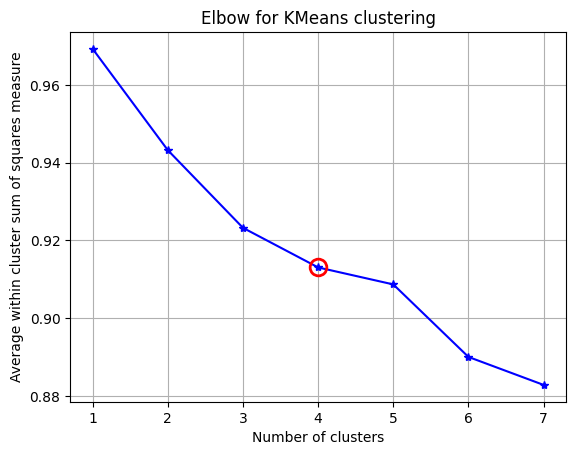

In [9]:
%matplotlib inline

D_k = [cdist(tfidf_matrix.toarray(), cent,'euclidean') for cent in centroids]  #euclidean as a distance measure
eucldist = [np.min(D,axis=1) for D in D_k]  #find minimum distance
avgWithinSM = [sum(d)/tfidf_matrix.shape[0] for d in eucldist]
kIdx = 3
# plot elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_clusters, avgWithinSM, 'b*-')
ax.plot(num_clusters[kIdx], avgWithinSM[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within cluster sum of squares measure')
plt.title('Elbow for KMeans clustering')

Relatively sharp elbow is at k=4, so selecting it as best K for this problem.

In [10]:
from sklearn.cluster import KMeans
best_K=4
model = KMeans(best_K)  
model.fit(tfidf_matrix)  #fit kmeans for k=4
clusters = model.labels_.tolist()
news = {'docs': docs,'cluster': clusters}  #create dictionary of docs and cluster
frame = pd.DataFrame(news, index = [clusters] , columns = ['cluster'])  #this frame will help in cross-tabulation

In [11]:
print('Number of documents per cluster')
frame['cluster'].value_counts()   #get total document count grouped in each cluster

Number of documents per cluster


cluster
3    83
1    64
2    36
0    13
Name: count, dtype: int64

In [12]:
totalvocab_lemmetized = []  #holds lemmetized tokens for all docs
for i in docs:
    allwords_lemmetized = tokenizer(i)   
    totalvocab_lemmetized.extend(allwords_lemmetized)  
#dataframe of lemmetized tokens. This will get to find most frequent words in a cluster
vocab_frame = pd.DataFrame({'words': totalvocab_lemmetized}, index = totalvocab_lemmetized)

Frequent words in clusters

In [14]:
print("Top terms per cluster:")
print()
l=['first','second','third','fourth']
#sort cluster centers by proximity to centroid
order_centroids = model.cluster_centers_.argsort()[:, ::-1] 

for i in range(best_K):
    print(l[i],"Cluster top words:", end='')
    for ind in order_centroids[i, :10]: #top 10 words per cluster
        word=vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        print(' %s' % word, end=',')
    print()
    print()

Top terms per cluster:

first Cluster top words: 损失, 信用, 信用, 应收款, 标准, 计量, 控制权, 准则, 基础, 方法,

second Cluster top words: 添加剂, 技术, 客户, 电池, 风险, 湿法, 湿法, 碱, 业务, 主营业务,

third Cluster top words: 电池, 政策, 产量, 投资人, 董事, 全球, 权, 添加剂, 拓邦, 高管,

fourth Cluster top words: 资产, 价值, 计量, 负债, 损益, 公允, 公允, 费用, 所得税, 金融资产,



In [16]:
indexlist=[]   #get list to plot legends
legendlist=[]
legendlist.append('Loss')
indices = [p for p, s in enumerate(docs) if '损失' in s]   #find doc index where mobile is present
indexlist.append(model.labels_[indices[0]])      
legendlist.append('Addon')
indices = [p for p, s in enumerate(docs) if '添加剂' in s] #find doc index where hospital is present
indexlist.append(model.labels_[indices[0]])
legendlist.append('Battery')
indices = [p for p, s in enumerate(docs) if '电池' in s]  #find doc index where cent is present
indexlist.append(model.labels_[indices[0]])
legendlist.append('Asset')
indices = [p for p, s in enumerate(docs) if '资产' in s]  #find doc index where game is present
indexlist.append(model.labels_[indices[0]])

In [99]:
tfidf_matrix

<196x334 sparse matrix of type '<class 'numpy.float64'>'
	with 3378 stored elements in Compressed Sparse Row format>

In [17]:
# Find the labels corresponding to each keyword
label_keyword_map = {}
legendlist = []
indexlist = []  # Initialize indexlist

# Find the labels corresponding to each keyword
for keyword in ['损失', '添加剂', '电池', '资产']:
    indices = [p for p, s in enumerate(docs) if keyword in s]
    if indices:
        label = model.labels_[indices[0]]
        label_keyword_map[label] = keyword
        if label not in indexlist:
            indexlist.append(label)

In [110]:
indexlist

[0, 2, 3]

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  func(*args, **kwargs)
/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  func(*args, **kwargs)
/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  func(*args, **kwargs)
/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 27744 (\N{CJK UNIFIED IDEOGRAPH-6C60}) missing from current font.
  func(*args, **kwargs)
/Users/liujeru/.pyenv/versions/doc/lib/python3.9/site-packages/IPython/core/ev

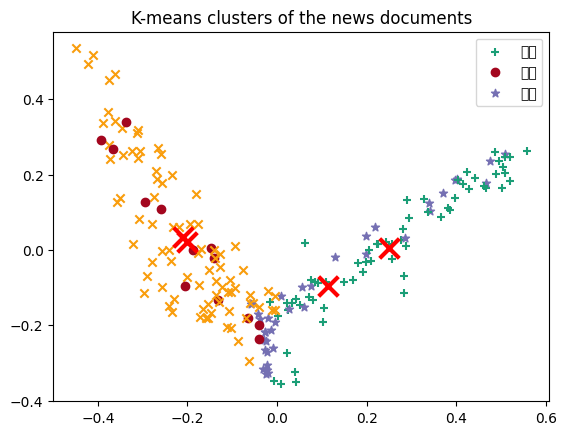

In [18]:
from sklearn.decomposition import PCA
import pylab as pl

plt.rcParams['font.family']=['SimHei']#关键是这句
# Convert the TF-IDF matrix to a NumPy array
#tfidf_matrix = np.asarray(tfidf_matrix.item())

from scipy.sparse import csr_matrix  # Import the csr_matrix function

# Convert sparse matrix to dense NumPy array
tfidf_matrix_dense = tfidf_matrix.todense().A

# Alternatively, you can use the csr_matrix function to convert it directly to a NumPy array
# tfidf_matrix_dense = csr_matrix(tfidf_matrix).A

pca = PCA(n_components=2).fit(tfidf_matrix_dense)  #convert sparse tf-idf to dense form
data2D = pca.transform(tfidf_matrix_dense)  # get 2-D representation


for i in range(0, data2D.shape[0]):  #plot PCA
    if model.labels_[i] == 1:
        c1 = plt.scatter(data2D[i,0],data2D[i,1],c='#1b9e77', marker='+')
    elif model.labels_[i] == 0:
        c2 = plt.scatter(data2D[i,0],data2D[i,1],c='#a3061e',marker='o')
    elif model.labels_[i] == 2:
        c3 = plt.scatter(data2D[i,0],data2D[i,1],c='#7570b3',marker='*')
    elif model.labels_[i] == 3:
        c4 = plt.scatter(data2D[i,0],data2D[i,1],c='#f99d0c',marker='x')
        
legendlist = [label_keyword_map[label] for label in indexlist]
plt.legend([c1, c2, c3, c4], legendlist)
#pl.legend([c1, c2, c3,c4],[legendlist[indexlist.index(1)],legendlist[indexlist.index(0)],legendlist[indexlist.index(2)],legendlist[indexlist.index(3)]])
pl.title('K-means clusters of the news documents')
    
centers2D = pca.transform(model.cluster_centers_)   #locate means
plt.scatter(centers2D[:,0], centers2D[:,1], 
           marker='x', s=200, linewidths=3, c='r')

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

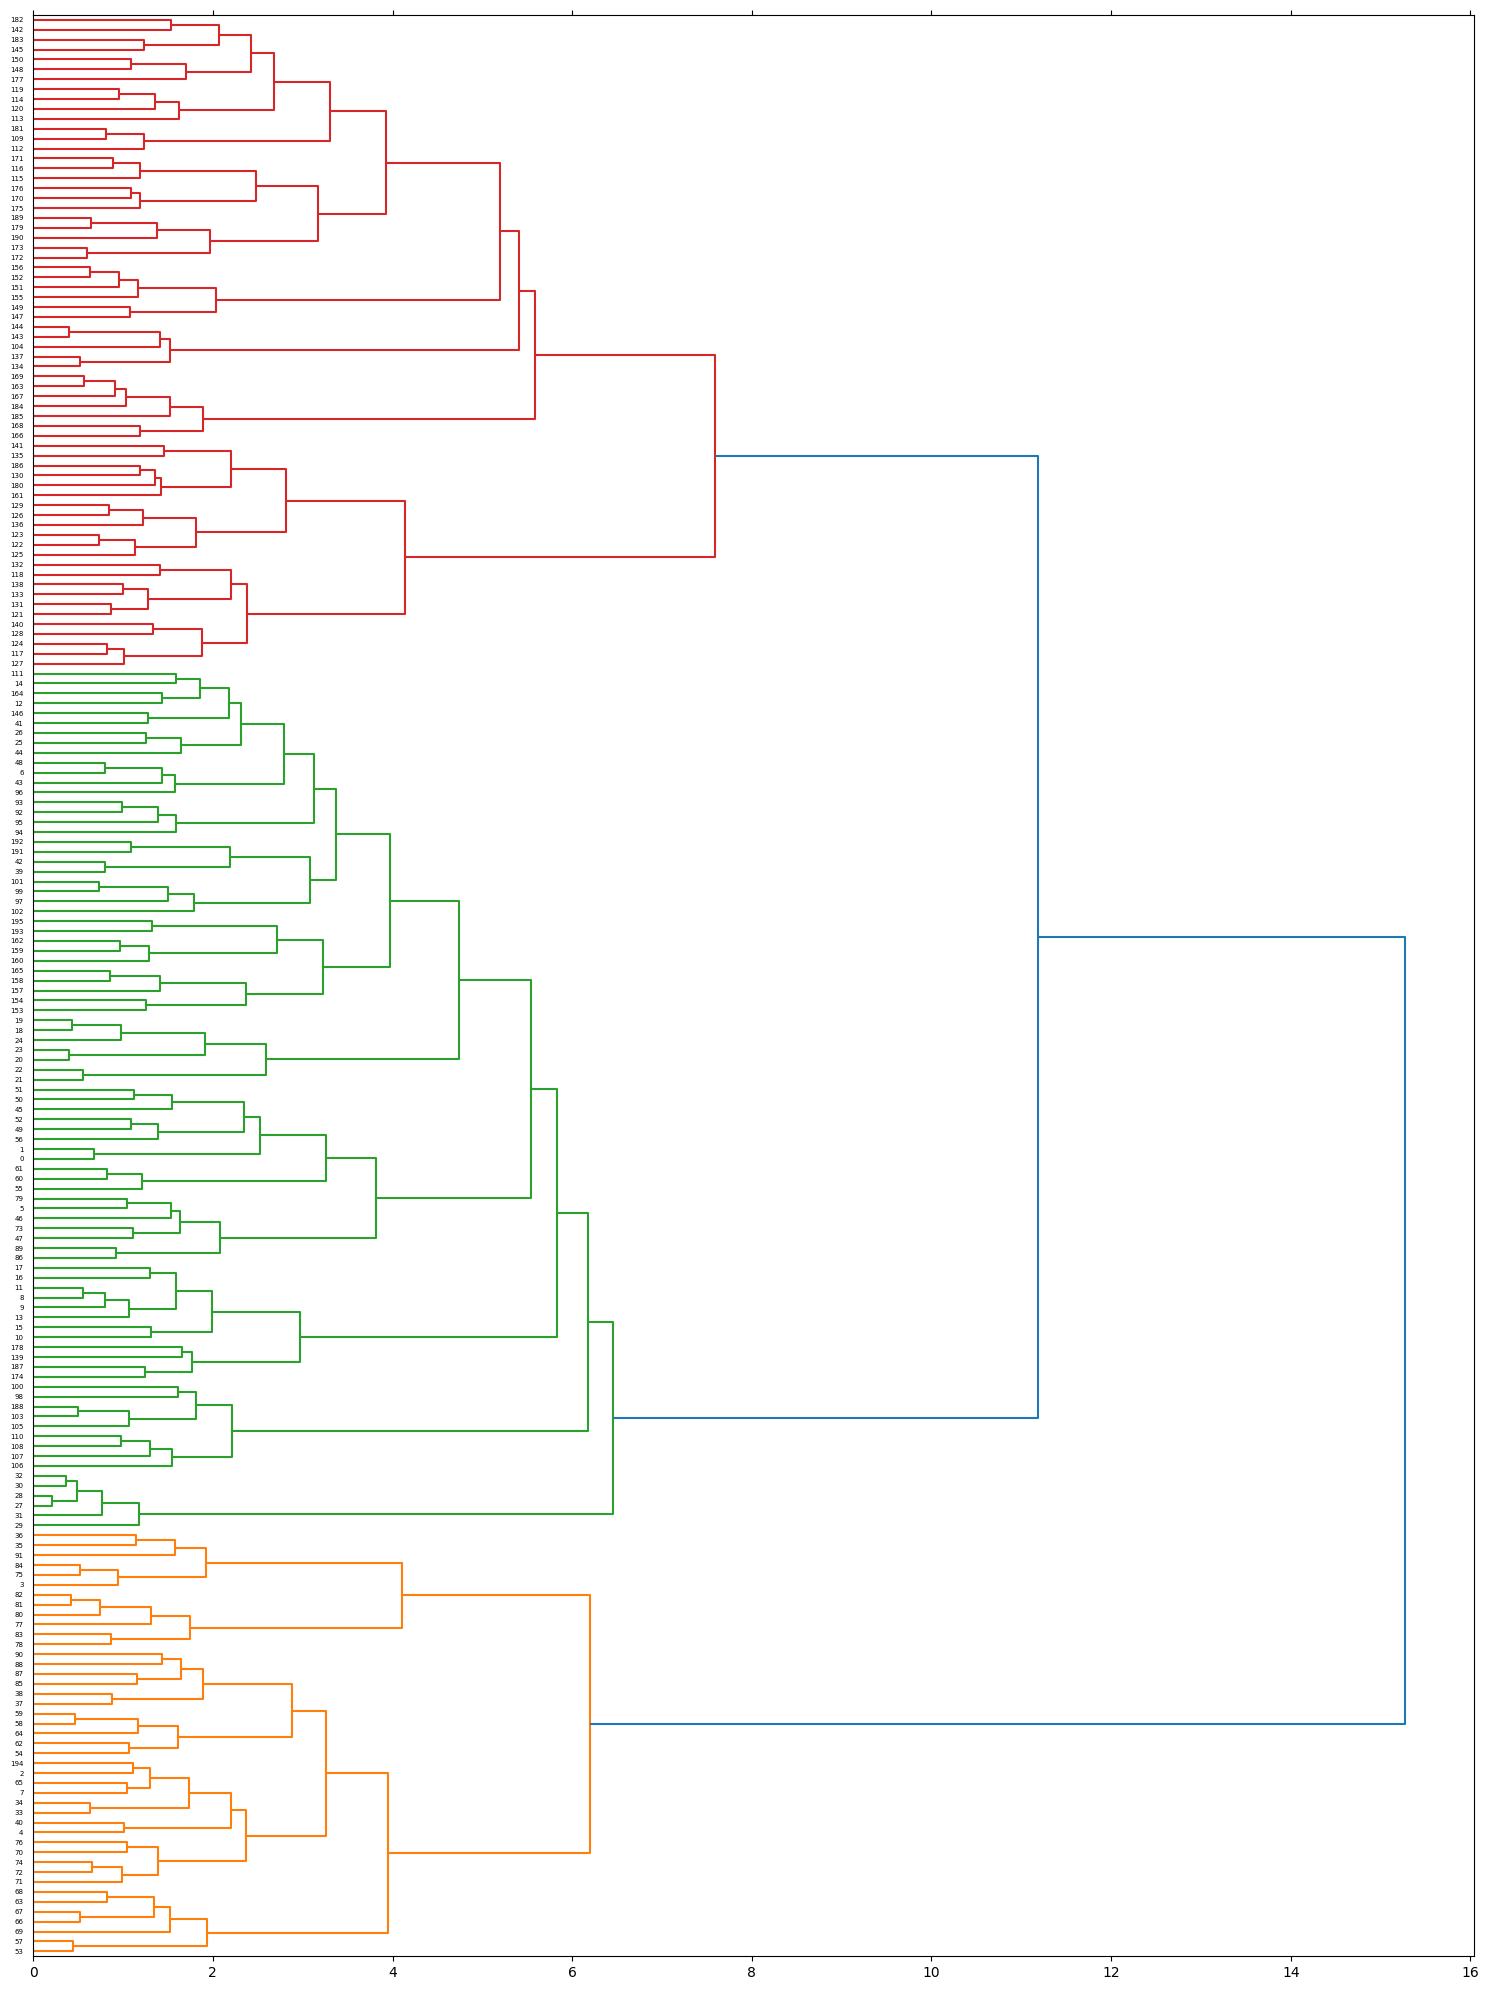

In [19]:
from scipy.cluster.hierarchy import ward,dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)   #using cosine distance
linkage_matrix = ward(dist)   #get linkage matrix using ward's method

fig, ax = plt.subplots(figsize=(15, 20)) # set size 
ax = dendrogram(linkage_matrix, orientation="right")   #get the dendrogram

plt.tick_params(   #set tick parameters
    axis= 'x',          
    which='both',     
    bottom='off',      
    top='off',        
    labelbottom='off')

plt.tight_layout()

In [23]:
print('2---', docs[2])
print('194---', docs[194])
print('7---', docs[7])
print('60---', docs[60])
print('4---', docs[4])
print('40---', docs[40])

2--- 公司是一家光伏用湿法添加剂研发、生产和销售的成长型创新创业企业，具备较强的自主研发和创新能力，且在碱抛添加剂市场销售占有率约为50%。公司产品属于复配型湿法添加剂，生产过程以物理混合为主。公司符合创业板行业领域及其依据，不存在主要依赖国家限制产业开展业务。主营业务及市场地位自主研发和创新能力客户覆盖范围生产和销售模式业态创新及新旧产业融合符合创业板定位相关要求主要财务数据和财务指标具体上市标准公司主营业务为光伏用湿法添加剂研发、生产和销售，主营业务收入规模逐年保持较快增长。公司在碱抛添加剂细分领域一直处于领先地位，目前市场销售占有率约为50%。公司的产品属于复配型湿法添加剂，生产过程以物理混合为主。公司具备较强的自主研发和创新能力，较早开发出太阳能电池碱抛添加剂并致力于碱抛光工艺的推广与落地。公司产品不断更新，针对不同客户、不同工艺和技术、不同生产环境、不同设备特点提供差异化的产品和服务方案。公司构建了产品研发和技术服务联动的特色业务模式。公司客户已覆盖行业内主要电池片生产企业，包括晶科能源、天合光能、润阳股份、晶澳科技及横店东磁等知名光伏电池厂商。
194--- 公司是一家专业的光伏用湿法添加剂研发、生产和销售企业，主营业务为碱抛添加剂、制绒添加剂、清洗添加剂等产品的生产和销售。公司深耕光伏用湿法添加剂领域多年，具备深厚技术积累，为公司主营业务的持续、稳定、健康发展奠定了良好基础。公司以客户合作、技术创新为使命，致力于为太阳能电池片生产企业提供高效率生产工艺和材料，提供综合性的太阳能电池片生产解决方案。公司坚持技术创新，在研发方面投入逐年递增，并取得了一系列的技术创新成果。公司业务持续稳健发展，坚持技术创新，提供高效率生产工艺和材料，为太阳能电池片生产企业提供综合性解决方案。公司专注光伏用湿法添加剂领域多年，具备深厚技术积累，业务持续稳健发展。
7--- 公司深耕光伏用湿法添加剂领域多年，较早开发出太阳能电池碱抛添加剂并致力于碱抛光工艺的推广与落地。目前市场销售占有率约为50%。
60--- 太阳能电池片产量持续攀升，其中我国产量占比逐年提高。根据中国光伏行业协会数据，2017-2021年全球及我国太阳能电池片产量持续攀升，2021年全球太阳能电池片产量达到224GW，同比增长37.36%，其中我国产量达到198GW，同比增长46.59%，国内电池片占全

In [25]:
print('109---', docs[109])
print('43---', docs[43])
print('50---', docs[50])

0--- 国金证券股份有限公司SINOLINK SECURITIES CO，LTD.首次公开发行股票并在创业板上市，公司主营业务为光伏用湿法添加剂的研发、生产和销售，产品主要运用于太阳能电池制备过程中的清洗制绒及刻蚀抛光环节。公司报告期内取得较快的增长，但存在产品销售价格下降、技术迭代及新产品开发、业务无法持续保持快速增长等风险。投资者应认真阅读招股说明书的全部内容并特别注意风险提示，同时关注利润分配政策及股东分红回报规划和重要承诺。
43--- 公司未发生污染事故和违规行为，同时生产过程中的废气、废水、废渣和噪声得到有效处理。公司所处的光伏产业符合国家经济发展战略的产业政策。环保合规情况具有符合国家经济发展战略的产业政策行业主管部门及监管体制行业主要法律法规公司主营业务收入和主营业务毛利率下游应用领域政策公司产品的市场竞争公司未来发展前景报告期内，公司存在未及时办理环评手续、排污许可手续的情况，但截至招股说明书签署日已完成整改。
50--- 光伏用湿法添加剂产品市场竞争主要集中在产品质量、价格、服务等方面。目前，市场上主要的竞争对手包括长春高新、鑫科材料、昌红科技等。公司在产品质量、技术研发和市场拓展方面具有一定的优势，但面临着市场竞争加剧的压力。


In [26]:
print('109---', docs[109])
print('117---', docs[117])
print('140---', docs[140])

109--- 存货包括产成品、商品、在产品、耗用材料、在途物资和委托加工物资等。计量采用实际成本，外购存货成本为采购成本加工成本，债务重组取得存货以公允价值或相关税费确定入账价值，非货币性资产交换以公允价值或账面价值确定入账价值，同一控制下的企业吸收合并取得存货按被合并方或公允价值确定入账价值，非同一控制下的企业吸收合并取得存货按公允价值确定入账价值。存货采用月末一次加权平均法计量，并按成本与可变现净值孰低计量。存货跌价准备按单个或类别计提，以市场价格为基础确定可变现净值，如减记影响消失，可转回。固定资产同时具备经济利益可能流入企业和成本能够可靠计量的条件，与其有关的后续支出符合条件计入成本，不符合计入当期损益。固定资产初始计量采用成本法。
117--- 金融工具包括金融资产、金融负债和权益工具。本公司根据管理金融资产的业务模式和金融资产的合同现金流量特征将金融资产分类为以摊余成本计量的金融资产、以公允价值计量且其变动计入其他综合收益的金融资产和以公允价值计量且其变动计入当期损益的金融资产。金融资产和金融负债在初始确认时以公允价值计量。对于以公允价值计量且其变动计入当期损益的金融资产和金融负债，相关的交易费用直接计入当期损益，对于其他类别的金融资产和金融负债，相关交易费用计入初始确认金额。
140--- 针对金融资产整体和部分转移的情况，需要按照一定方法计算差额并计入当期损益。对于金融负债的回购一部分，需要按照继续确认部分和终止确认部分在回购日各自的公允价值占整体公允价值的比例对该金融负债整体的账面价值进行分配，分配给终止确认部分的账面价值与支付的对价之间的差额，计入当期损益。


In [5]:
docs = ['国金证券股份有限公司SINOLINK SECURITIES CO，LTD.首次公开发行股票并在创业板上市，公司主营业务为光伏用湿法添加剂的研发、生产和销售，产品主要运用于太阳能电池制备过程中的清洗制绒及刻蚀抛光环节。公司报告期内取得较快的增长，但存在产品销售价格下降、技术迭代及新产品开发、业务无法持续保持快速增长等风险。投资者应认真阅读招股说明书的全部内容并特别注意风险提示，同时关注利润分配政策及股东分红回报规划和重要承诺。', '公司概况经营成果产品与市场投资者关注事项发行人基本情况利润分配政策承诺事项国金证券股份有限公司SINOLINK SECURITIES CO，LTD.首次公开发行股票并在创业板上市。公司主营业务为光伏用湿法添加剂的研发、生产和销售，产品主要运用于太阳能电池制备过程中的清洗制绒及刻蚀抛光环节。公司报告期内取得较快的增长，但存在风险需关注。公司报告期内经营成果显著，营业收入和净利润均保持较快的增速。2020-2022年营业收入复合增长率为67.42%，归属于母公司所有者净利润的复合增长率约为44.66%。公司主要从事光伏用湿法添加剂的研发、生产和销售，产品主要运用于太阳能电池制备过程中的清洗制绒及刻蚀抛光环节。投资者应关注利润分配政策及股东分红回报规划和重要承诺。投资者需要了解发行人及本次发行的中介机构基本情况。公司制定了利润分配政策及上市后三年股东分红回报规划。投资者需要关注本次发行相关责任方作出的重要承诺。投资者应认真阅读招股说明书全文并了解公司的主要风险，以作出正确的投资决策。', '公司是一家光伏用湿法添加剂研发、生产和销售的成长型创新创业企业，具备较强的自主研发和创新能力，且在碱抛添加剂市场销售占有率约为50%。公司产品属于复配型湿法添加剂，生产过程以物理混合为主。公司符合创业板行业领域及其依据，不存在主要依赖国家限制产业开展业务。主营业务及市场地位自主研发和创新能力客户覆盖范围生产和销售模式业态创新及新旧产业融合符合创业板定位相关要求主要财务数据和财务指标具体上市标准公司主营业务为光伏用湿法添加剂研发、生产和销售，主营业务收入规模逐年保持较快增长。公司在碱抛添加剂细分领域一直处于领先地位，目前市场销售占有率约为50%。公司的产品属于复配型湿法添加剂，生产过程以物理混合为主。公司具备较强的自主研发和创新能力，较早开发出太阳能电池碱抛添加剂并致力于碱抛光工艺的推广与落地。公司产品不断更新，针对不同客户、不同工艺和技术、不同生产环境、不同设备特点提供差异化的产品和服务方案。公司构建了产品研发和技术服务联动的特色业务模式。公司客户已覆盖行业内主要电池片生产企业，包括晶科能源、天合光能、润阳股份、晶澳科技及横店东磁等知名光伏电池厂商。', '公司销售技术团队重点改善公司产品在客户产线中的运用问题，提升产品的使用效果，增加客户的粘性。研发团队根据公司获取的大量产品使用参数及客户产线情况有针对性地开发出适用于特定客户的产品并持续迭代创新。公司按照在手订单+合理预测的方式组织生产，并采取以直销为主的销售模式。公司采购的原材料主要包括包装桶等包装材料以及促进剂A、羧甲基纤维素钠等基础化学品。主要供应商包括供应商A、供应商B、昆山紫鼎塑胶有限公司、昆山康特塑业科技有限公司等。', '公司较早投入到碱抛工艺的研究并成功开发出碱抛添加剂，助力碱抛工艺的快速推广。相较于传统的酸抛工艺，碱抛工艺能够避免硝酸的使用，减轻了环境污染并降低了环保处理成本，同时提升了电池背面的反射率，为光伏行业降本增效提供了新材料。公司生产的太阳能电池片添加剂并非单一配方、大规模生产的标准品，而是针对不同客户、不同工艺和技术、不同生产环境、不同设备特点提供差异化的产品和服务方案。', '公司符合创业板行业领域及其依据，产品属于C3985电子专用材料制造和6.3.2太阳能材料制造。公司行业分类准确，不存在所属行业分类变动的可能，也不存在主要依赖国家限制产业开展业务。', '公司选择符合创业板定位相关指标及其依据，是一家成长型创新创业企业。公司报告期内主营业务收入规模逐年保持较快增长，2020年至2022年复合增长率为67.36%。报告期各期，公司主营业务收入分别为8,303.76万元、15,082.72万元和23,258.68万元。', '公司深耕光伏用湿法添加剂领域多年，较早开发出太阳能电池碱抛添加剂并致力于碱抛光工艺的推广与落地。目前市场销售占有率约为50%。', '公司选择符合创业板定位相关指标及其依据，是一家成长型创新创业企业，具备较强的自主研发和创新能力。公司符合创业板行业领域及其依据，不存在主要依赖国家限制产业开展业务。公司符合上市标准且未存在公司治理特殊安排。募集资金将用于研发和扩充产能等方面，同时公司将深耕主营业务和应用市场，提升创新能力并优化产品结构。然而，公司面临多项风险，包括技术迭代及新产品开发风险、核心技术人员流失或不足的风险、核心技术泄密的风险、业务无法持续保持快速增长的风险、产品结构单一风险、生产经营场所租赁风险、产品销售价格下降带来毛利率波动的风险和应收账款坏账风险。此外，实际控制人控制不当的风险也存在。', '上市标准与公司治理募集资金用途与未来发展规划技术迭代及新产品开发风险核心技术人员流失或不足的风险核心技术泄密的风险业务无法持续保持快速增长的风险其他风险管理水平与发展速度不匹配的风险根据深交所创业板股票上市规则，公司符合上市标准且未存在公司治理特殊安排。募集资金将主要用于研发和扩充产能等方面，并根据实际情况先行投入自筹资金。公司将深耕主营业务和应用市场，提升创新能力并优化产品结构。', '公司在技术迭代及新产品开发方面存在风险，可能对公司盈利能力产生不利影响。公司的核心技术人员是公司发展的保证，如未提供更好的发展空间、更具市场竞争力的薪酬待遇和更适合的研发条件，公司将面临技术人才不足的风险。公司若在生产经营过程中核心技术及相关保密信息泄露，将会在一定程度上影响公司的市场竞争力，对公司的生产经营和发展产生不利影响。', '公司存在业务无法持续保持快速增长的风险，可能对公司的盈利水平产生不利影响。公司还存在产品结构单一风险、生产经营场所租赁风险、产品销售价格下降带来毛利率波动的风险和应收账款坏账风险。此外，实际控制人控制不当的风险也存在。', '随着公司的生产规模和产品结构的变化，公司的管理水平在机制建立、战略规划、组织设计、运营管理、资金管理和内部控制等方面将面临较大的挑战。如果后续公司的管理水平无法适应公司的发展速度及规模，可能会对公司的经营产生不利影响。', '绍兴拓邦新能源股份有限公司存在多种风险，包括政策变化、原材料价格波动、市场竞争加剧、募集资金投资项目风险、股东回报被摊薄、环境风险、发行失败风险以及股权结构变化。这些风险可能对公司经营业绩产生不利影响。政策风险原材料价格风险市场竞争风险投资项目风险股东回报风险环境风险发行风险股权结构变化光伏行业政策变化可能对公司经营业绩产生不利影响。公司需关注政策变化，提前做好应对措施，以减少不利影响。', '公司生产所需的主要原材料价格受物料价格波动的影响较大，未来原材料价格持续上涨将对公司盈利能力产生不利影响。公司需通过配方迭代、合理规划采购量等方式降低原材料价格波动对公司经营业绩的影响。', '随着光伏行业的发展，行业现有竞争者之间的竞争加剧，同时存在潜在进入者进入公司领域的可能；若公司无法及时提升技术和研发能力，产品迭代升级不及时，将面临市场份额下降以及现有产品被竞争的风险。', '公司本次发行募集资金拟用于投资项目，在项目达产或销售计划未能按时实现时，公司将面临因折旧、摊销增加而导致短期内利润下滑的风险。本次发行完成后，公司净资产和总股本将有较大幅度的增长，短期内公司存在由于净资产规模扩大导致每股收益、净资产收益率等下降，股东即期回报被摊薄的风险。', '公司生产过程中会产生废水、固体废弃物等污染物，其排放量将随着公司生产规模的持续扩大而增加，因此未来可能会出现对污染物处置不当造成环境污染的情况，或者因工作人员操作不当、疏忽等原因受到环保部门处罚的风险。公开发行结果受多种内外部因素影响可能导致发行失败，公司需做好发行准备工作，降低失败风险。', '公司曾发生股权结构变化，投资者需关注变化对公司经营的影响。拓邦有限股东会同意将注册资本增加至100万元，并进行股权转让。拓邦新能召开股东大会，增加注册资本并将资本公积金转增为股本。拓邦有限与投资人签署了对赌协议，包括多项特别权利。新投资人与拓邦有限签署的增资协议中也约定了特别权利条款。本轮新投资人自动享有前轮投资人根据对赌协议享有的投资人特别权利。', '拓邦有限股东会决议增资拓邦有限股权转让拓邦新能增资拓邦新能转增股本拓邦有限与投资人签署的对赌协议新投资人与拓邦有限签署的增资协议本轮新投资人自动享有前轮投资人的投资人特别权利2021年7月20日，拓邦有限股东会决议将公司注册资本增加至100万元，其中新股东琪花异果、经论思守分别出资7.50万元、5万元，原股东张震华、李一鸣分别增加出资22.50万元、15万元。中汇会计师于2021年11月29日出具验资报告，确认公司已收到上述股东缴纳的新增注册资本合计50万元。', '2021年11月24日，拓邦有限股东会决议将公司股权转让给多个投资人。张震华、李一鸣将其持有的公司股权分别转让给绍拓合伙、绍邦合伙、锦冠壹号、诚毅欣锐、东磁投资、祥禾涌原、海邦投资、李仙德、陈康平、章镔洁。投资人根据对赌协议享有多项特别权利，包括优先认购权、股权转让限制、共售权、随售权、反稀释权、优先清算权、处置权、最优惠权等。', '2022年5月27日，拓邦新能召开股东大会，同意将公司股本由500万股增至517.8572万股，由新投资人以1,200.00万元货币认购4.7619万股、申能联毅以1,000.00万元货币认购3.9683万股、海邦投资以1,000.00万元货币认购3.9683万股、王斌达以1,300.00万元货币认购5.1587万股。中汇会计师于2022年6月15日出具验资报告，确认拓邦新能已经收到前述股东缴纳的增资款4,500万元，其中17.8572万元计入注册资本，超出注册资本的部分计入资本公积。', '2022年6月17日，拓邦新能召开第二次临时股东大会，同意将资本公积金转增为股本，注册资本由517.8572万元增加至5,000万元，总股本增加至5,000万股。中汇会计师于2022年7月8日出具验资报告，确认上述出资已足额缴纳。', '拓邦有限与投资人签署的对赌协议包括优先认购权、股权转让限制、共售权、随售权、反稀释权、优先清算权、处置权、最优惠权等。', '新投资人与拓邦有限签署的增资协议中约定了投资人特别权利条款。根据拓邦新能与新投资人签署的增资协议，本轮新投资人自动享有前轮投资人根据对赌协议享有的投资人特别权利。发行人与投资人之间的特殊股东权利条款已解除且无效，不存在对赌约定，公司无重大资产重组，有2家全资子公司和1家分公司，张震华为控股股东、实际控制人，持股无质押或争议，其他持股5%以上的主要股东为李一鸣及其控制的企业。特殊股东权利条款已解除不存在对赌约定公司子公司情况控股股东、实际控制人情况其他持股5%以上的主要股东情况根据《关于绍兴拓邦新能源股份有限公司投资相关事项之补充协议》和《关于绍兴拓邦新能源股份有限公司增资协议之补充协议》，投资人特别权利条款已终止无效，发行人股权回购义务豁免。保荐机构和发行人律师核查后确认，所有涉及投资方特殊股东权利的条款已解除且无效，不存在对发行人本次发行造成重大不利影响的情况。截至本招股说明书签署日，发行人与其股东之间及发行人股东之间不存在尚未解除的对赌约定的情形。', '截至本招股说明书签署日，公司共有2家全资子公司，分别为倍利嘉、拓宇新能，分公司1家，绍兴拓邦新能源股份有限公司盐城分公司。公司还有全资子公司鼎嘉新材，已于2022年12月注销；参股公司玖芯新材未开展实际经营，已于2020年12月注销。', '截至本招股说明书签署日，张震华为控股股东、实际控制人，直接持有公司35.8014%股权，并持有其他公司股份。其持股不存在质押、冻结或其他有争议的情况。除控股股东、实际控制人外，其他持有公司5%以上股份的主要股东为李一鸣及其控制的企业。', '本公司高管及核心技术人员的基本情况包括3名高管和5名核心技术人员；公司董事、监事的提名和选聘情况经过股东表决一致同意选举产生；公司高管及核心技术人员未在公司及其子公司外兼职；公司董事、监事、高管及核心技术人员之间不存在亲属关系；除少数人员外，上述人员及其近亲属未持有公司股份；上述人员对外投资情况与公司无利益冲突；公司高管及核心技术人员薪酬由基础年薪和绩效年薪构成，独立董事仅领取津贴而不享受福利待遇；公司目前不存在股权激励及其他制度安排。', '公司高管及核心技术人员基本情况公司董事、监事的提名和选聘情况公司高管及核心技术人员的兼职情况公司董事、监事、高管及核心技术人员之间的亲属关系上述人员及其近亲属持有公司股份的情况上述人员的对外投资情况上述人员的薪酬情况公司股权激励及其他制度安排公司有3名高管和5名核心技术人员，其中张震华、李一鸣、潘海洋是高管，张震华、李一鸣、桑丹义、吴冰、赵晶是核心技术人员。赵晶先生是公司的研发经理，持有大专学历，现年32岁。', '公司董事、监事的提名和选聘情况如下：2022年1月26日召开的创立大会选举产生了张震华、李一鸣、张漫江、潘海洋、罗妍等人为公司第一届董事会董事，其中罗妍为公司独立董事，任期三年；2022年3月16日股东大会选举产生了夏钢和沈永嘉为公司独立董事，任期至本届董事会任期届满之日止；因独立董事罗妍辞职，2022年9月19日股东大会选举产生了徐强国为公司独立董事，任期至本届董事会任期届满之日止。公司高管及核心技术人员未在公司及其子公司外兼职。', '除了董事长、总经理张震华与公司董事张漫江为胞兄弟之外，公司董事、监事、高管及核心技术人员之间不存在亲属关系。上述人员及其近亲属持有公司股份的情况如下：除上述情况外，本次发行前无其他董事、监事、高管及核心技术人员及其近亲属以任何方式直接或间接持有本公司股份的情况。上述董事、监事、高管及核心技术人员及其近亲属直接或间接持有的本公司的股份不存在质押或冻结以及其他争议或潜在纠纷的情况。', '上述人员对外投资情况如下：公司董事、监事、高管及核心技术人员及其他核心人员的对外投资与公司均不存在利益冲突。上述人员的薪酬情况如下：除独立董事外，其余董事、监事、高管及核心技术人员在本公司领取基础年薪及绩效年薪，并依法享有养老、工伤、失业、医疗、生育等社会保险及住房公积金福利。独立董事在公司仅领取独立董事津贴，不享有福利待遇。公司董事的薪酬标准由薪酬与考核委员会拟定方案，报经董事会同意后，提交股东大会审议通过；高管的薪酬标准由薪酬与考核委员会拟订并经董事会审议通过。', '公司目前不存在正在执行的对其董事、监事、高管及核心技术人员、员工实行的股权激励（如限制性股票、股票期权）及其他制度安排。', '公司是一家专业从事太阳能电池片湿法添加剂研发、生产和销售的高新技术企业，具有丰富的行业经验和核心竞争力。公司主要产品包括碱抛添加剂、制绒添加剂、清洗添加剂等多种添加剂的产品系列，能够满足当前主流PERC电池及下一代N型电池对湿法添加剂的需求。公司长期坚持自主研发模式，具备完善的研发体系和高素质的研发团队，成功实现成熟产品的快速迭代和新产品种类的不断丰富。公司主要客户为润阳股份、天合光能及晶科能源等主要电池片厂商，具备较强的回款稳定性和客户粘性。公司采取直销模式，主要通过展会、行业会议及上门拜访等方式获得测试机会，并根据客户需求匹配相对应的产品，在其产线测试并获得认可后报价，与客户签订供货合同。', '公司业务概述公司研发能力公司客户公司营收情况公司销售模式公司采购管理公司关键竞争因素公司生产排产公司是一家专业从事太阳能电池片湿法添加剂研发、生产和销售的高新技术企业，具有丰富的行业经验和核心竞争力。公司主要产品包括碱抛添加剂、制绒添加剂、清洗添加剂等多种添加剂的产品系列，能够满足当前主流PERC电池及下一代N型电池对湿法添加剂的需求。公司长期坚持自主研发模式，具备完善的研发体系和高素质的研发团队，成功实现成熟产品的快速迭代和新产品种类的不断丰富。公司的关键竞争因素为持续研发满足电池片厂商需求的添加剂产品，帮助电池片厂商实现持续降本增效。', '公司的研发方向与行业前沿技术的发展、下游客户的需求紧密结合，形成了成熟的研发流程体系。公司主要客户为润阳股份、天合光能及晶科能源等主要电池片厂商，具备较强的回款稳定性和客户粘性。公司采取直销模式，主要通过展会、行业会议及上门拜访等方式获得测试机会，并根据客户需求匹配相对应的产品，在其产线测试并获得认可后报价，与客户签订供货合同。公司营业收入呈现快速增长态势，2020年至2022年复合增长率为67.42%，持续保持高速增长。公司的盈利关键性因素为是否能够持续研发出满足电池片厂商需求的添加剂产品，帮助电池片厂商实现持续降本增效。公司采取直销模式，主要通过展会、行业会议及上门拜访等方式获得测试机会，并根据客户需求匹配相对应的产品，在其产线测试并获得认可后报价，与客户签订供货合同。公司的销售服务团队重点改善公司产品在客户产线中的运用问题，提升产品的使用效果，增加客户的粘性，同时将产品的实际运用效果和问题及时反馈给研发团队。公司建立健全了采购管理制度和供应链体系，主要运用以产定购的采购模式，保证了原材料质量稳定性和供货及时性。公司的材料采购由采购部统一负责，生产部、研发部、质量部共同参与，采购产品主要有高纯原料、包材及辅材等。公司的关键竞争因素为持续研发满足电池片厂商需求的添加剂产品，帮助电池片厂商实现持续降本增效。', '依托成熟的研发体系和高素质的研发团队，公司成功实现成熟产品的快速迭代和新产品种类的不断丰富，充分满足下游电池片行业对于持续降本增效的需求。公司生产经营活动围绕客户需求展开，根据预计销售情况安排采购与生产，生产完成后进行交货。除正常客户订单需求外，公司会综合考虑物流情况、客户采购预期、交货周期及其他特殊情况适当调整排产计划。', '湿法添加剂是太阳能电池片制备过程中的关键材料之一，对太阳能电池片的光电转换效率有直接影响，并能够有效降低环境处理成本。针对产品配方的研究开发、迭代改良、客户适配，是公司核心竞争力的重要来源。公司是一家注重环保的、具备严格的生产和质量管理体系的湿法添加剂供应商。公司紧跟下游行业内的新变化，不断拓宽产品品类，并且采用在手订单+合理预测的方式组织生产，以客户需求为导向。公司生产的主要产品为太阳能电池片制备过程中清洗制绒和刻蚀抛光所需的湿法添加剂。公司的经营模式受下游应用领域的技术特点和客户需求影响较大，公司未来将依托现有客户资源及研发优势，进一步开发原硅片清洗剂、助焊剂及导电胶等产品。', '公司概况产品介绍经营模式质量管理体系环境保护情况经营演变未来发展公司支出情况公司是一家注重环保的湿法添加剂供应商，成立于2011年。公司生产的产品属于复配型湿法添加剂，生产过程以物理混合为主，采用在手订单+合理预测的方式组织生产，并建立了严格的生产管理规程和质量管理体系，并通过了ISO9001:2015质量管理体系认证。公司生产的主要产品为太阳能电池片制备过程中清洗制绒和刻蚀抛光所需的湿法添加剂。产品工艺流程包括清洗、制绒和刻蚀抛光。公司紧跟下游行业内的新变化，不断拓宽产品品类，并且采用在手订单+合理预测的方式组织生产，以客户需求为导向。公司的经营模式受下游应用领域的技术特点和客户需求影响较大，公司根据客户需求采用在手订单+合理预测的方式组织生产，同时持续加大研发投入，丰富产品种类。未来，公司将依托现有客户资源及研发优势，进一步开发原硅片清洗剂、助焊剂及导电胶等产品。公司建立了严格的质量管理体系，并通过了ISO9001:2015质量管理体系认证。对原材料、中间产品、成品、包装材料均有严格的检验制度，充分规范产品检测流程，保证产品质量稳定。', '公司注重环境保护，生产经营活动符合国家有关环保要求，未发生过环保事故，未因违反国家环保法律、行政法规和地方性规章而受到环保部门行政处罚。公司生产经营过程中产生的主要污染物为废水、废气、固体废弃物和噪声，各污染物对应的污染源及处理措施得到严格遵守，公司环保支出主要用于污水站的设立、污水处理费用、固废处理费用等。', '公司在起步阶段投入到PERC电池背抛光的研究，并较早开发出碱抛添加剂产品。提升阶段公司不断提升碱抛工艺技术，改进碱抛添加剂产品，并成功将传统氢氟酸/硝酸的工艺体系改造氢氧化钠/氢氧化钾+碱抛添加剂的新型抛光路线。', '发展阶段公司进入快速发展阶段，不断加大研发投入、丰富产品种类，并且进一步加深与主要公司的业务合作。公司未来将依托现有客户资源及研发优势，进一步开发原硅片清洗剂、助焊剂及导电胶等产品。同时，公司将继续紧跟下游行业内的新变化，不断拓宽产品品类，并且采用在手订单+合理预测的方式组织生产，以客户需求为导向。', '公司环保支出逐年增大，主要用于污水站的设立、污水处理费用、固废处理费用等。2021年及2022年公司的环保设施投入大幅增加，主要系公司建立污水处理站的投入。公司未发生过环保事故，未因违反国家环保法律、行政法规和地方性规章而受到环保部门行政处罚。公司在报告期内存在未及时办理环评和排污许可手续的情况，但已经整改完成。', '公司未发生污染事故和违规行为，同时生产过程中的废气、废水、废渣和噪声得到有效处理。公司所处的光伏产业符合国家经济发展战略的产业政策。环保合规情况具有符合国家经济发展战略的产业政策行业主管部门及监管体制行业主要法律法规公司主营业务收入和主营业务毛利率下游应用领域政策公司产品的市场竞争公司未来发展前景报告期内，公司存在未及时办理环评手续、排污许可手续的情况，但截至招股说明书签署日已完成整改。', '根据瀚川环保科技股份有限公司的环保核查报告，公司未发生污染事故和违规行为，同时生产过程中的废气、废水、废渣和噪声得到有效处置。经绍兴市生态环境局越城分局确认，公司已经履行了必要的环评手续和排污许可手续，报告期内未及时办理环评手续的情况已经整改完毕。上述情况不会对本次发行上市构成重大不利影响。', '光伏产业是我国国家经济发展战略中得到大力支持的产业之一。公司所处的光伏用湿法添加剂产品主要应用于太阳能电池片的生产环节，位于光伏产业链的中游，符合国家经济发展战略的产业政策。同时，公司属于C39计算机、通信和其他电子设备制造业下的C3985电子专用材料制造，也符合国家产业政策的发展方向。', '公司所属行业的主管行政部门包括国家发展和改革委员会、工业和信息化部和国家能源局。国家发改委主要发挥宏观调控职能，国家能源局作为国家发改委管理的机构，主要职责为拟订并组织实施能源发展战略、规划和政策。在行业监管方面，国家质检局、国家安监局和公安部分别负责化工行业的产品质量、标准化、安全生产、危险化学品生产经营、非药品类易制毒化学品生产经营等方面的监督管理。发行人所属行业的自律性组织为中国电子材料行业协会、中国光伏行业协会和中国可再生能源学会。', '公司产品属于电子专用材料制造行业，相关的主要法律法规包括《危险化学品安全管理条例》、《企业职业病危害因素分类目录和代码》、《安全生产法》等。此外，公司还需遵守产品标准和质量标准等相关法律法规。', '公司主营业务收入和主营业务毛利率是对公司具有核心意义的业务指标。其变动对业绩变动具有较强预示作用。', '公司产品主要应用于太阳能电池片的生产环节。在下游应用领域，相关政策包括《建筑节能条例》、《智能制造发展规划》等。这些政策的出台和实施，对公司产品的应用和市场拓展具有积极的推动作用。', '光伏用湿法添加剂产品市场竞争主要集中在产品质量、价格、服务等方面。目前，市场上主要的竞争对手包括长春高新、鑫科材料、昌红科技等。公司在产品质量、技术研发和市场拓展方面具有一定的优势，但面临着市场竞争加剧的压力。', '光伏产业是我国国家经济发展战略中得到大力支持的产业之一，公司所处的光伏用湿法添加剂产品也符合国家产业政策的发展方向。公司产品具有广阔的市场空间，未来发展前景值得期待。同时，公司将继续加强技术研发和市场拓展，提高产品质量和服务水平，不断提升市场竞争力。', '光伏行业在国家政策支持和市场需求的双重推动下，呈现快速发展态势。公司的光伏添加剂产品在太阳能电池片生产环节有重要作用，是电池片制造降本增效的重要材料之一。我国光伏产业链已形成全球最完整的产业链，制造端的全球市场份额进一步向国内集中。光伏行业的政策调整促进了行业逐步完成由政策驱动向市场驱动的转换，降本提效成为行业发展的关键因素。', '光伏发电技术以其环保、无污染、节约能源的特点，符合国家对环境保护的日益重视和可持续能源发展的需求。党的二十大报告明确提出我国需要构建新的增长引擎，其中光伏行业是其中的代表之一。光伏电池制备技术路线持续更新，不断提高太阳能电池片的光电转换效率。', '光伏行业的发展趋势公司的光伏添加剂产品我国的光伏产业链光伏行业的政策调整光伏发电技术的优势新的增长引擎光伏电池制备技术的更新可再生能源的发展趋势光伏行业受到政策支持和市场需求的双重推动，呈现快速发展态势。全球光伏累积装机容量已经迅速增长至2021年的843GW，预计未来将有较大的市场增长空间。我国光伏新增装机量有望由2021年的54.88GW增长至2025年的110GW。公司的光伏添加剂产品主要应用于太阳能电池片的生产环节，是电池片制造降本增效的重要材料之一。优质的光伏添加剂在提高太阳能电池片光电转换效率、加快电池片制备速率以及减少制备过程中化学品消耗等方面具有重要意义。', '我国光伏产业链已形成全球最完整的产业链，制造端的全球市场份额进一步向国内集中。我国多晶硅料、硅片、电池片及组件的产量占全球产量的比重均超过了70%。', '光伏行业作为可再生能源发展的代表之一，符合国家对环境保护的日益重视和可持续能源发展的需求。光伏行业的政策调整促进了行业逐步完成由政策驱动向市场驱动的转换，降本提效成为行业发展的关键因素。2018年以后光伏行业的政策出现了较大程度的调整，但同时也促进了光伏行业逐步完成由政策驱动向市场驱动的转换。', '光伏发电技术以其环保、无污染、节约能源的特点，符合国家对环境保护的日益重视和可持续能源发展的需求。光伏行业作为可再生能源发展的代表之一，具有广阔的市场前景。党的二十大报告明确提出我国需要构建新的增长引擎，其中光伏行业是其中的代表之一。发展光伏产业同样是我国实现减排目标的重要举措。光伏电池制备技术路线持续更新，不断提高太阳能电池片的光电转换效率。光伏行业作为可再生能源发展的代表之一，具有广阔的市场前景。全球各国出台碳达峰、碳中和政策，进一步推动可再生能源的发展，而光伏发电作为其中的代表之一，具有广阔的市场前景。', '光伏用湿法添加剂行业需求增长主要受到电池片产量增加和降本提效需求驱动。随着太阳能电池片产量不断攀升，添加剂在电池片制备过程中的作用变得越来越重要。电池技术路线的迭代将对添加剂行业产生影响，但公司产品仍有着较为坚实的市场基础。公司的创新特征包括技术创新、模式创新、业态创新和新旧产品的融合，正在研发新型添加剂产品。', '光伏用湿法添加剂行业需求情况太阳能电池片产量情况添加剂在电池片制备过程中的作用电池技术路线的迭代对添加剂行业的影响公司产品市场基础公司的创新特征公司添加剂产品公司的未来发展光伏用湿法添加剂行业的需求增长主要受到电池片产量的增加和降本提效的需求驱动。随着光伏行业的发展，太阳能电池片的产量不断攀升，电池片制造企业对添加剂的需求也随之增加。同时，政府政策引导下，降本增效已成为光伏行业的发展趋势与要求，电池片企业对添加剂的使用也更加重视。', '太阳能电池片产量持续攀升，其中我国产量占比逐年提高。根据中国光伏行业协会数据，2017-2021年全球及我国太阳能电池片产量持续攀升，2021年全球太阳能电池片产量达到224GW，同比增长37.36%，其中我国产量达到198GW，同比增长46.59%，国内电池片占全球产量的比重也由2017年的69.23%提升至2021年的88.39%。', '硅片是电池片生产过程中最为关键的原材料，硅片产量和产能的充足性直接关系到电池厂商的开工率，国内硅片产能和产量持续扩张，为电池片产量的增加提供了保障。', '添加剂在电池片制备过程中具有重要作用，可以降低用量和提高反应效率。太阳能电池片添加剂是电池片制备过程中降本增效的关键之一，优质的添加剂一方面能够有效降低制绒、刻蚀、清洗等环节中化学品用量，有效降低电池片企业的原材料成本和环保处理成本；另一方面可以加速反应速率并提高电池片的光电效率，对电池片制备环节的降本增效具有重要意义。', '电池技术路线的迭代将对添加剂行业产生影响。随着电池技术的迭代，比如单晶PERC电池的市场份额逐年提升，但随着PERC电池转换效率逐渐接近理论极限，具有更高转换效率的N型TOPCon及HJT电池技术逐渐受到关注，各电池技术市场占比的变化趋势也在发生变化。未来随着电池技术的不断发展，添加剂的需求量和类型也将不断变化。公司产品依旧有着较为坚实的市场基础。', '太阳能电池片产量不断增加，电池片制备过程中添加剂的需求量也随之增加，作为行业内的龙头企业，公司的添加剂产品在市场上有着较高的知名度和认可度，公司产品的市场基础比较稳固。公司的创新特征包括技术创新、模式创新、业态创新和新旧产品的融合。公司在技术创新方面一直积极探索，在添加剂的研发方面也有着较高的投入。同时，公司在发展过程中也积极探索新的业态和模式，注重产品的融合和创新。', '公司的添加剂产品包括碱抛添加剂、刻蚀抛光添加剂等。碱抛添加剂可以降低碱对磷硅玻璃的腐蚀速率，同时对裸硅起到加速腐蚀的作用，从而实现硅片在短时间的腐蚀。刻蚀抛光添加剂则可以保证电池片表面的平整度和光洁度，从而提高电池片的光电转换效率。公司正在研发新型添加剂产品，未来将继续保持技术创新和产品创新的势头，注重业态的拓展和模式的创新，以适应行业发展和市场需求的变化。随着光伏行业的快速发展和电池技术的不断进步，公司的产品有望在未来取得更大的市场份额和更高的市场竞争力。', '公司专注于太阳能电池片湿法工艺的研究，致力于研发、生产和销售太阳能电池片湿法添加剂，通过不断的技术创新和产品升级，满足下游电池厂商的降本提效需求，同时关注下一代N型TOPCon及HJT电池技术发展趋势，开发适用的产品。公司已率先推出碱抛添加剂产品取代含氮废水较多的酸抛光工艺，同时开发了针对TOPCon电池技术的特殊问题的技术和适用于新型电池技术路线的超低反射率技术，以及水基型组件用助焊剂技术。公司长期以来坚持将技术发展同市场需求深度结合，保障公司在行业内的技术地位。', '公司专注于太阳能电池片湿法工艺的研究不断进行技术创新和产品升级碱抛添加剂产品的推出针对TOPCon电池技术的特殊问题的技术和超低反射率技术的开发水基型组件用助焊剂技术的开发技术发展与市场需求的结合以客户需求为导向的研究工作公司的专业性和技术地位公司自成立以来始终专注于太阳能电池片湿法工艺的研究，致力于研发、生产和销售太阳能电池片湿法添加剂，积累了丰富的行业经验。公司不断进行技术创新和产品升级，针对不同客户需求开发出多款添加剂产品，如TB178、TB186、TB20、BP150、BP63、BP21等系列产品，同时关注下一代N型TOPCon及HJT电池技术发展趋势，开发出EP系列和PR系列产品。', '公司率先推出碱抛添加剂产品，配合氢氧化钠/氢氧化钾碱抛光工艺，取代含氮废水较多的酸抛光工艺，降低了环保处理成本、提高了生产效率和光电转换效率，目前已被主流电池厂商广泛采用。公司开发的TOPCon电池绕镀非晶硅层腐蚀技术和超低反射率技术，能够解决TOPCon电池技术在湿法工艺中的特殊问题，满足下一代N型电池路线的需求，以及适用于新型电池技术路线的超低反射率技术。公司较早开发水基型组件用助焊剂技术，用于组件生产过程中的焊接电池片环节，能够有效去除焊带表面，提高组件生产效率和质量。', '公司研发人员和研发费用保持快速增长，分别为29人、47人和65人，研发费用分别为675.27万元、1,362.92万元和2,477.85万元，公司长期以来坚持将技术发展同市场需求深度结合，保障公司在行业内的技术地位。公司凭借多年的研发沉淀和行业经验积累，对太阳能电池片湿法工艺的特点、下游主流电池片制造企业的需求以及未来光伏行业主要技术路线的发展趋势形成了深刻的认识，始终以客户需求为导向，开展相应的研究工作。', '公司专业从事太阳能电池片湿法添加剂的研发、生产和销售，积累了丰富的行业经验，目前已建立了较为完善的技术创新研发体系，在立足当下主流P型PERC电池技术的需求前提下，紧跟下一代N型TOPCon及HJT电池技术发展趋势，帮助下游电池厂商实现降本提效的现实需求。公司在光伏用湿法添加剂领域具备丰富的经验和先进的技术，成功研发了无机碱抛添加剂等多种产品。公司的产品能够降低环境污染、降本增效，满足客户需求，并得到广泛应用。公司采取产品研发和技术服务联动的特色业务模式，推动产品研发迭代和应用落地，促进公司与客户的深度融合，并将不断加强研发和创新能力，探索光伏行业降本增效新路径。', '公司的行业地位公司的技术水平和特点公司的市场销售占有率公司的竞争对手公司的应用效果和反响公司的业务模式公司的发展前景公司的产品种类公司是国内深耕光伏用湿法添加剂的企业，拥有多年经验和丰富的行业经验，并成功研发了无机碱抛添加剂，在碱抛添加剂细分领域处于领先地位。公司的核心技术包括水基型助焊剂技术、超低反射率制绒技术等，可根据不同客户需求提供定制化产品和服务方案。公司客户已覆盖行业内主要电池片生产企业，销售占有率约为50%，制绒添加剂销量也在逐步增长。', '公司拥有先进的技术和核心技术，如水基型助焊剂技术、超低反射率制绒技术等，能够根据不同客户需求提供定制化产品和服务方案。公司研发的无机碱抛添加剂可降低环境污染并降本增效，满足客户需求，并得到广泛应用。公司采取产品研发和技术服务联动的特色业务模式，推动产品研发迭代和应用落地，促进公司与客户的深度融合。公司在碱抛添加剂方面拥有较大的市场销售占有率，约为50%，制绒添加剂销量也在逐步增长。公司拥有丰富的行业经验和技术积累，逐渐占据太阳能电池片添加剂细分领域主要市场份额。公司将不断加强研发和创新能力，探索光伏行业降本增效新路径。', '全球湿电子化学品企业可分为欧美企业、日本企业和韩国/中国企业三类，公司的主要竞争对手为在中国台湾地区的东应化和格林达等企业。', '公司拥有丰富的行业经验和技术积累，逐渐占据太阳能电池片添加剂细分领域主要市场份额。公司的产品能够降低环境污染、降本增效，满足客户需求，并得到广泛应用。公司的无机碱抛添加剂能够避免硝酸的使用，减轻了环境污染并降低了环保处理成本，同时提升了电池背面的反射率，为光伏行业降本增效提供新材料。公司采取产品研发和技术服务联动的特色业务模式，推动产品研发迭代和应用落地，促进公司与客户的深度融合。', '公司采取产品研发和技术服务联动的特色业务模式，销售技术团队重点改善公司产品在客户产线中的运用问题，提升产品的使用效果，增加客户的粘性，同时将产品的实际运用效果和问题及时反馈给研发团队；研发团队根据公司获取的大量产品使用参数及客户产线情况有针对性地开发出适用于特定客户的产品并持续迭代创新。上述双向循环的正向作用，既能够推动公司不断研发迭代新产品，又能够促进产品应用落地、激发客户对产品的进一步需求。', '全球湿电子化学品企业在光伏用湿法添加剂领域的竞争愈加激烈，公司拥有丰富的行业经验和技术积累，逐渐占据太阳能电池片添加剂细分领域主要市场份额。受益于碳达峰、碳中和能源供给侧改革的推进，公司光伏用湿法添加剂近年来获得了持续的动力，公司将不断加强研发和创新能力，促进产品的迭代升级，与客户需求深度融合，共同探索光伏行业降本增效新路径。公司将进一步向上游原硅片清洗环节及下游组件环节延伸，丰富公司产品的种类。公司新开发的超低反射率制绒技术适用于下一代N型电池技术路线，通过该核心技术开发的产品目前已经在客户的产线中进行调试。公司拥有丰富的行业经验和技术积累，将不断加强研发和创新能力，探索光伏行业降本增效新路径。', '安集微电子科技、唯特偶、时创能源、小辰科技和三峰能源分别是半导体材料、微电子焊接材料、光伏材料、太阳能电池制备材料和电池片制绒添加剂等领域的重要企业。它们具有强大的研发能力和技术积累，能够满足不同客户的需求，并采用产品研发和技术服务联动的特色业务模式。这些企业与太阳能电池片企业形成了稳定的合作关系，为行业发展注入了活力。', '安集微电子科技唯特偶时创能源小辰科技三峰能源安集微电子科技的竞争优势安集微电子科技的特色业务模式安集微电子科技的产品结构安集微电子科技是一家自主创新型高科技微电子材料企业，专注于半导体材料的研发和产业化。公司具有强大的研发能力和技术积累，能够满足不同客户的需求。基于对碱抛光技术的深厚理解，抛光添加剂产品具有优异的表面刻蚀与表面清洗性能，具有工艺窗口宽、性能稳定等多项优势。公司采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。', '唯特偶是一家专注于微电子焊接材料的研发、生产及销售企业，主要产品包括锡膏、焊锡丝、焊锡条等微电子焊接材料以及助焊剂、清洗剂等辅助焊接材料。公司的产品广泛应用于PCBA制程、精密结构件连接、半导体封装等多个产业环节的电子器件的组装与互联，并最终广泛应用于消费电子、LED、智能家电、通信、计算机、工业控制、光伏、汽车电子、安防等多个行业。', '时创能源是一家高科技企业，为全国100多家光伏企业提供太阳能晶硅电池制绒辅助剂、硅片抛光液和高效电池工艺设备等多项产品和服务。公司能够满足不同客户的需求，具有强大的研发能力和技术积累。公司采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。', '小辰科技主要经营范围是单晶硅制绒添加剂、多晶硅制绒添加剂的生产制造、研发、销售及太阳能电池的技术开发、技术咨询、技术服务等。公司具有强大的研发能力和技术积累，能够满足不同客户的需求，并采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。', '三峰能源是一家专注于太阳能电池片制备材料的企业，主要产品包括单晶制绒添加剂、酸/碱抛光添加剂、多晶金刚线制绒添加剂和高效清洗剂等。公司具有强大的研发能力和技术积累，能够满足不同客户的需求，并采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。', '安集微电子科技具有强大的研发能力和技术积累，以及多样化的配方工艺和产品结构，满足不同客户的需求。公司采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。公司配备专业研发团队，并建立了完备的研发制度。公司在碱抛光技术的探索和开发中已具备大量的实验数据和配方积累，在新产品的改进和开发上具备明显的先发优势。', '安集微电子科技采用产品研发和技术服务联动的特色业务模式，提供差异化的产品和服务方案。销售技术团队重点改善公司产品在客户产线中的运用问题，提升产品的使用效果，增加客户的粘性，同时将产品的实际运用效果和问题及时反馈给研发团队。研发团队根据公司获取的大量产品使用参数及客户产线情况有针对性地开发出适用于特定客户的产品并持续迭代创新。', '安集微电子科技经过多年研发，已建立起多样化的配方工艺和产品结构，能够满足不同太阳能电池片客户对于添加剂的多样化需求。公司目前产品覆盖晶硅太阳能电池碱抛添加剂、无醇型单晶硅制绒添加剂、清洗添加剂、TOPCon电池去除poly添加剂等多种类型，包括数十种细分型号，能够满足客户在太阳能电池片制备过程中的各种添加剂需求。全球光伏装机量不断增长，为公司提供了发展机遇，但公司需加大研发投入和产能建设以满足市场需求。公司急需补充高端人才以充实关键环节。国家政策大力支持湿电子化学品行业发展，为公司创造了良好的政策环境。我国是全球光伏制造大国，为公司提供了广阔的应用空间和市场支撑。光伏行业规模持续扩大，为相关湿法添加剂的需求带来了广阔的发展空间，但行业竞争加剧，需要不断提升产品质量和开发新产品。光伏用湿法添加剂行业生产及研发人才储备较为稀少，制约了行业的快速发展。时创能源、安集科技、唯特偶是公司同行业可比公司。发展机遇人才需求政策环境市场支撑增长空间竞争压力人才储备可比公司比较近年来，全球光伏装机量不断增长，为公司提供了发展机遇。', '随着各国政府对光伏产业的扶持不断加强和降本增效的推进，湿法添加剂的需求量和技术要求也在不断提升。但公司现有产能已无法满足下游客户旺盛的需求，需要加大研发投入和产能建设。公司急需补充大量从事湿法添加剂领域的高端人才，以充实到关键原材料、配方迭代、工艺改善、生产升级、渠道拓展以及公司运营的各个环节中。随着行业内市场竞争的逐渐加剧，对于高端人才的争夺会愈发激烈，公司目前高端人才尚待补充，这在一定程度上制约了公司的快速发展。国家政策大力支持湿电子化学品行业发展，为公司提供了良好的政策环境。湿电子化学品是制造显示面板、半导体、太阳能电池等产品的关键材料之一，随着制造业的高速发展和制造转型的推进，国家对湿电子化学品的扶持力度不断加大，为发行人提供了发展的机遇。', '我国是全球光伏制造大国，为发行人提供了广阔的应用空间和市场支撑。光伏行业在硅料、硅片、电池和组件等重要环节全球产能占比均已超过70%，为光伏用湿法添加剂行业带来了重要的市场支撑。发行人凭借技术积累和本土服务的优势，不断与下游客户加深合作，共同为光伏行业降本增效提供助力。光伏行业规模持续扩大，为相关湿法添加剂的需求带来了广阔的发展空间。国家政策的积极扶持和技术突破的持续推动，使光伏发电成本不断下降，光伏行业已经具备平价上网的基本条件，在没有补贴的情况下实现盈利。光伏产业的发展显著拉动了相关湿法添加剂的需求，为包括发行人在内的专注光伏领域的供应商带来了广阔的发展空间。行业竞争加剧对公司的不利影响。为提升市场份额保持竞争优势，光伏用湿法添加剂供应商纷纷通过新产品迭代和老产品降价的方式巩固与新老厂商的合作，另一方面行业内亦开始出现新进入者，对添加剂行业的竞争格局形成一定的挑战。随着光伏行业产能的持续扩张及产品与技术的迭代升级，公司产品的价格将长期处于下降的趋势，需要不断提升现有产品质量，开发出新产品，以应对竞争压力。', '光伏用湿法添加剂行业生产及研发人才储备较为稀少，制约了行业的快速发展。', '国内湿电子化学品产业是伴随着电子产业向内陆转移而逐步形成的新兴产业。相较于下游行业的迫切需求，其生产及研发人才储备相对更为稀少，制约了该行业的快速发展。公司急需补充大量从事湿法添加剂领域的高端人才，以充实关键环节。按照业务涉及湿电子化学品、产品功能具有一定的相似性、利润规模与发行人相近等标准，发行人选择时创能源、安集科技、唯特偶作为同行业可比公司。虽然时创能源的光伏湿制程辅助品业务与发行人业务较为接近，但两者的产品结构有所不同。行业竞争加剧对公司的不利影响，需要不断提升产品质量和开发新产品。', '公司光伏添加剂业务主要应用于电池片生产，与安集科技的化学机械抛光液应用领域不同。公司与同行业可比公司存在差异，但在2022年1-6月的收入规模和利润规模已接近可比公司。公司的主要产品光伏添加剂产能逐年增加，产销率和产能利用率处于较高水平，前五大客户销售额未超过总销售额的50%。公司主营业务按产品类别和销售地区划分，主要产品价格变动稳定。公司光伏湿法添加剂业务与时创能源可比，唯特偶公司的清洗剂产品与公司清洗添加剂不完全可比。公司持续加大研发投入，引进行业高端人才，研发投入保持在较高水平。公司与前五大客户不存在关联关系和利益倾斜的情形。公司与同行业可比公司差异公司产品应用领域的差异公司与可比公司的收入规模和利润规模公司的主要产品及产能情况公司主营业务收入情况公司业务与可比公司的比较公司的研发投入情况公司与前五大客户的关系公司在经营情况、市场地位、技术实力、主要应用领域及客户等方面与同行业可比公司存在差异。公司的光伏添加剂业务主要应用于光伏领域的电池片生产，而安集科技生产的化学机械抛光液主要应用于半导体领域，两者应用领域不同。公司的收入规模和利润规模于2022年1-6月与可比公司接近，但在之前的报告期内低于可比公司。公司持续加大研发投入，研发费用率逐年稳步上升，逐步与可比公司接近。公司的主要产品为光伏添加剂，产能逐年增加，产销率和产能利用率处于较高水平。前五大客户销售额未超过总销售额的50%。公司主营业务按产品类别和销售地区划分，主要产品价格变动稳定。公司与同行业可比公司存在差异，但与时创能源的光伏湿法添加剂业务可比。唯特偶公司的清洗剂产品与公司清洗添加剂在应用领域不同，两者不完全可比。', '公司持续加大研发投入，优化升级自身研发平台和改善研发环境，引进行业高端人才，研发投入保持在较高水平。公司不存在与前五大客户存在利益倾斜的情形，且与前五大客户之间不存在关联关系。前五大客户销售额未超过总销售额的50%。', '公司高度保护和不断创新核心技术，积累了多项专利技术和专有技术，构建了产业链上下游贯通的技术创新平台。公司的科技实力和成果体现在多个荣誉和专利数量上，持续增强核心技术人员对企业文化的认同感，为公司长期发展奠定坚实基础。公司正在从事的主要研发项目和研发投入占营业收入比例均有逐年增加的趋势。公司未涉足境外经营。', '核心技术保护和创新科技实力和成果主要研发项目和投入技术创新平台和人才引进财务会计数据和重要性判断审计意见和关键审计事项公司高度重视对核心技术的保护，通过为核心技术申请专利保护、对核心技术进行保密管理以及同核心技术人员签订《竞业禁止协议》及《保密协议》等一系列保护措施，避免核心技术的泄露。', '公司具备多项专利技术和专有技术，以自主研发为核心，积极探索产学研技术交流和合作，构建产业链上下游贯通的技术创新平台。公司的科技实力和成果体现在多个荣誉和专利数量上，公司是国家高新技术企业，获得国家工信部专精特新小巨人企业、浙江省科技型中小企业、浙江省高新技术企业研究开发中心、市级企业研究开发中心、市级企业技术中心、绍兴市第五批重点创新团队、2022年越城区区长质量奖等多项荣誉。公司拥有多项专利技术和专有技术，持续增强核心技术人员对企业文化的认同感，为公司长期发展奠定坚实基础。公司未涉足境外经营。', '公司以自主研发为核心，积极探索产学研技术交流和合作，构建产业链上下游贯通的技术创新平台。公司持续推进技术创新人才管理体系建设，并建立了人才储备机制，对关键技术岗位的技术人员实行储备。未来，公司将积极引进行业内高端技术创新人才，持续充实公司技术创新人才队伍，持续激发研发人员的主动性、创造性。', '公司根据自身所处的行业发展阶段等实际情况，从业务的性质和金额两方面判断财务信息的重要性。在性质方面，公司重视经常性业务，评估业务是否显著影响公司的财务状况、经营成果和现金流量等因素。在评价项目金额大小的重要性时，公司主要采用主营业务收入确定财务报表重要性水平，具体金额为主营业务收入的1%。', '本招股说明书中引用的财务数据均经过审计，审计报告未发现重大问题。公司重视关键审计事项，在审计过程中积极配合，保证审计工作的顺利进行。中汇所根据职业判断，将收入确认和应收账款减值确定为关键审计事项。针对这些事项，审计程序主要包括了解内部控制、检查会计政策及具体方法、选取样本检查合同、执行分析程序、选择主要客户函证、检查支持性文件等。', '本公司以持续经营为基础，根据企业会计准则及其他相关规定编制财务报表。报告期纳入合并财务报表范围的子公司共3家，其中增加了2家。营业收入的确认以控制权转移作为判断标准。应收账款坏账准备以单项金额重大或按信用风险组合计量预期信用损失为基础计算。新收入准则下，公司在客户取得相关商品控制权时确认收入。', '关键审计事项收入确认审计程序应收账款减值审计程序财务报表编制基础合并财务报表范围及变化情况收入确认的会计政策应收账款坏账准备的计算基础新收入准则下的收入确认中汇所根据职业判断，认为收入确认和应收账款减值是最为重要的审计事项。', '针对收入确认，审计程序主要包括了解、测试与收入确认相关的内部控制制度的设计和执行；复核收入确认的会计政策及具体方法是否符合企业会计准则的规定、行业的特点，以及是否正确且一贯地运用；选取样本检查销售合同，识别与商品控制权转移相关的合同条款与条件，评价收入确认时点是否符合企业会计准则的要求；对收入和成本执行分析程序，分析毛利率变动情况，复核收入的合理性；结合应收账款审计，选择主要客户函证销售金额，并抽查收入确认的相关单据，检查已确认收入的真实性；针对境内销售，通过全国企业信用信息公示系统对重要客户进行工商资料查询；检查与收入确认相关的支持性文件，包括销售合同、销售订单、出库单、销售发票、签收单等，评价相关收入确认是否符合公司收入确认的会计政策；针对境外销售，向海关获取出口数据并与公司账面记录进行比对；检查与收入确认相关的支持性文件，包括销售合同、发货单、出库单、出口专用发票、报关单、提单等；就资产负债表日前后确认的收入，选取样本，核对出库单及其他支持性证据，以评价收入是否被记录于恰当的会计期间。', '针对应收账款减值，审计程序主要包括了解与应收账款减值相关的关键内部控制，评价这些控制的设计，确定其是否得到执行，并测试相关内部控制的运行有效性；复核以前年度已计提坏账准备的应收账款的后续实际核销或转回情况，评价管理层过往预测的准确性；复核管理层有关应收账款坏账准备的会计政策，检查所采用的坏账准备计提会计政策的合理性，分析比较本年及以前年度的应收账款坏账准备的合理性及一致性；检查对于按照单项金额重大的和按照信用风险组合确认坏账准备的区分标准是否恰当；复核管理层对于应收账款坏账准备的计算是否正确；对重要应收账款与管理层讨论其可收回性，并实施独立函证程序以及检查重要应收账款期后回款情况，评价管理层计提应收账款坏账准备的合理性；检查与应收账款减值相关的信息是否已在财务报表中作出恰当列报。', '本公司以持续经营为基础，根据企业会计准则及其他相关规定编制财务报表。报告期纳入合并财务报表范围的子公司共3家，其中增加了2家。', '营业收入的确认以控制权转移作为判断标准。公司在履行了合同中的履约义务，即在客户取得相关商品控制权时确认收入。新收入准则下，公司以控制权转移作为收入确认时点的判断标准。当履约进度不能合理确定时，公司已经发生的成本预计能够得到补偿的，按照已经发生的成本金额确认收入，直到履约进度能够合理确定为止。', '应收账款坏账准备以单项金额重大或按信用风险组合计量预期信用损失为基础计算。管理层根据各项应收账款的信用风险特征，以单项应收账款或应收账款组合为基础，按照相当于整个存续期内的预期信用损失金额计量其损失准备。对于以单项为基础计量预期信用损失的应收账款，管理层综合考虑有关过去事项、当前状况以及未来经济状况预测的合理且有依据的信息，估计预期收取的现金流量，据此确定应计提的坏账准备；对于以组合为基础计量预期信用损失的应收账款，管理层以账龄为依据划分组合，参照历史信用损失经验，并根据前瞻性估计予以调整，据此确定应计提的坏账准备。', '新收入准则下，公司在客户取得相关商品控制权时确认收入。满足下列条件之一的，公司属于在某一时段内履行履约义务；否则，属于在某一时点履行履约义务：（1）客户在公司履约的同时即取得并消耗公司履约所带来的经济利益；（2）客户能够控制公司履约过程中在建的商品；（3）公司履约过程中所产出的商品具有不可替代用途，且公司在整个合同期间内有权就累计至今已完成的履约部分收取款项。', '对于在某一时段内履行的履约义务，公司在该段时间内按照履约进度确认收入，但是，履约进度不能合理确定的除外。当履约进度不能合理确定时，公司已经发生的成本预计能够得到补偿的，按照已经发生的成本金额确认收入，直到履约进度能够合理确定为止。', '公司在确认收入时，考虑多种迹象来判断客户是否取得商品控制权。合同中含多项履约义务时，按比例分摊交易价格至各单项履约义务计量收入。可变对价按期望值或最可能发生金额确定，不超过累计已确认收入极可能不会重大转回的金额。境内销售以签收单为确认凭证，境外销售以提单为确认凭据。存货按实际成本计量，可变现净值低于成本计价。固定资产按成本法计量，符合确认条件的后续支出计入成本。永续盘存制是存货盘存制度。', '收入确认销售方式存货计量固定资产计量总结1总结2公司在客户取得相关商品控制权时点确认收入，考虑多种迹象，包括收款权利、法定所有权、实物占有、主要风险和报酬转移、客户接受和其他迹象。合同中含多项履约义务时，按比例分摊交易价格至各单项履约义务计量收入。可变对价按期望值或最可能发生金额确定，不超过累计已确认收入极可能不会重大转回的金额。合同中存在重大融资成分的，按假定客户现金支付的应付金额确定交易价格，差额采用实际利率法摊销。间隔不超过一年的交易，不考虑重大融资成分。境内销售方式下，公司已送达合同约定交货地点且客户已签收的产品，公司在异议期限届满时视同验收并确认收入，以签收单为确认凭据。境外销售方式下，公司已报关并取得提单的产品，公司在异议期限届满时视同验收并确认收入，以提单为确认凭据。', '存货包括产成品、商品、在产品、耗用材料、在途物资和委托加工物资等。计量采用实际成本，外购存货成本为采购成本加工成本，债务重组取得存货以公允价值或相关税费确定入账价值，非货币性资产交换以公允价值或账面价值确定入账价值，同一控制下的企业吸收合并取得存货按被合并方或公允价值确定入账价值，非同一控制下的企业吸收合并取得存货按公允价值确定入账价值。存货采用月末一次加权平均法计量，并按成本与可变现净值孰低计量。存货跌价准备按单个或类别计提，以市场价格为基础确定可变现净值，如减记影响消失，可转回。固定资产同时具备经济利益可能流入企业和成本能够可靠计量的条件，与其有关的后续支出符合条件计入成本，不符合计入当期损益。固定资产初始计量采用成本法。', '公司在确认收入时，考虑多种迹象来判断客户是否取得商品控制权。合同中含多项履约义务时，按比例分摊交易价格至各单项履约义务计量收入。可变对价按期望值或最可能发生金额确定，不超过累计已确认收入极可能不会重大转回的金额。合同中存在重大融资成分的，按假定客户现金支付的应付金额确定交易价格，差额采用实际利率法摊销。间隔不超过一年的交易，不考虑重大融资成分。', '境内销售方式下，公司已送达合同约定交货地点且客户已签收的产品，公司在异议期限届满时视同验收并确认收入，以签收单为确认凭据。境外销售方式下，公司已报关并取得提单的产品，公司在异议期限届满时视同验收并确认收入，以提单为确认凭据。', '存货按实际成本计量，可变现净值低于成本计价。固定资产按成本法计量，符合确认条件的后续支出计入成本。永续盘存制是存货盘存制度。', '确定固定资产入账价值的方法和计提折旧的规定，对融资租入固定资产的认定依据和计价方法进行了阐述。金融工具的分类、确认依据和计量方法得到明确规定，金融资产和金融负债在初始确认时以公允价值计量。在建工程按建造该项资产达到预定可使用状态前所发生的实际成本计量，融资租入的固定资产采用与自有固定资产一致的政策计提租赁资产折旧。公司至少年度终了对固定资产的使用寿命、预计净残值和折旧方法进行复核。', '确定固定资产入账价值和计提折旧规定融资租入固定资产的认定和计价金融工具的分类和计量方法金融资产的分类和计量方法在建工程计量规定融资租入固定资产的折旧计提固定资产复核和折旧计提固定资产达到预定可使用状态前或研发过程中产出的产品或副产品形成的固定资产以直接成本确定其入账价值，不包含与之相关的其他成本的分摊金额。固定资产自达到预定可使用状态时次月开始计提折旧，终止确认时或划分为持有待售非流动资产时停止计提折旧。如固定资产各组成部分的使用寿命不同或为企业提供经济利益方式不同，则选择不同折旧率和折旧方法，分别计提折旧。', '当本公司租入的固定资产符合以下标准之一或数项时，确认为融资租入固定资产：（1）在租赁期届满时租赁资产的所有权转移给本公司；（2）本公司有购买租赁资产的选择权，所订立的购买价款预计将远低于行使选择权时租赁资产的公允价值；（3）即使资产的所有权不转移，但租赁期占租赁资产使用寿命的大部分；（4）本公司在租赁开始日的最低租赁付款额现值，几乎相当于租赁开始日租赁资产公允价值；出租人在租赁开始日的最低租赁收款额现值，几乎相当于租赁开始日租赁资产公允价值；（5）租赁资产性质特殊，如果不作较大改造，只有本公司才能使用。', '融资租赁租入的固定资产，按租赁开始日租赁资产公允价值与最低租赁付款额的现值两者中较低者，作为入账价值。最低租赁付款额作为长期应付款的入账价值，其差额作为未确认融资费用。', '金融工具包括金融资产、金融负债和权益工具。本公司根据管理金融资产的业务模式和金融资产的合同现金流量特征将金融资产分类为以摊余成本计量的金融资产、以公允价值计量且其变动计入其他综合收益的金融资产和以公允价值计量且其变动计入当期损益的金融资产。金融资产和金融负债在初始确认时以公允价值计量。对于以公允价值计量且其变动计入当期损益的金融资产和金融负债，相关的交易费用直接计入当期损益，对于其他类别的金融资产和金融负债，相关交易费用计入初始确认金额。', '以摊余成本计量的金融资产是指符合以下条件的金融资产：本公司管理该金融资产的业务模式是以收取合同现金流量为目标；该金融资产的合同条款规定，在特定日期产生的现金流量，仅为对本金和以未偿付本金金额为基础的利息的支付。该类金融资产在初始确认后采用实际利率法以摊余成本计量，所产生的利得或损失在终止确认、按照实际利率法摊销或确认减值时，计入当期损益。对于金融资产的摊余成本，应当以该金融资产的初始确认金额经下列调整后的结果确定：扣除已偿还的本金；加上或减去采用实际利率法将该初始确认金额与到期日金额之间的差额进行摊销形成的累计摊销额；扣除累计计提的减值准备。', '在建工程同时满足经济利益很可能流入、成本能够可靠地计量则予以确认。在建工程达到预定可使用状态时，按工程实际成本转入固定资产。已达到预定可使用状态但尚未办理竣工结算的，先按估计价值转入固定资产，待办理竣工决算后再按实际成本调整原暂估价值，但不再调整原已计提的折旧。', '融资租入的固定资产采用与自有固定资产一致的政策计提租赁资产折旧。能够合理确定租赁期届满时将会取得租赁资产所有权的，在租赁资产尚可使用年限内计提折旧；无法合理确定租赁期届满时能够取得租赁资产所有权的，在租赁期与租赁资产尚可使用年限两者中较短的期间内计提折旧。公司至少年度终了对固定资产的使用寿命、预计净残值和折旧方法进行复核，如发生改变则作为会计估计变更处理。固定资产自达到预定可使用状态时次月开始计提折旧，终止确认时或划分为持有待售非流动资产时停止计提折旧。如固定资产各组成部分的使用寿命不同或为企业提供经济利益方式不同，则选择不同折旧率和折旧方法，分别计提折旧。', '金融资产和金融负债可分为三类和四类，分别采用不同的计量方法。', '公允价值计量且其变动计入其他综合收益的金融资产的合同条款规定现金流量仅为本金和利息支付。不同类型的金融工具在终止确认时需计入当期损益或留存收益。嵌入衍生工具按公允价值计量，减值应按资产组情况评估计提。金融资产分类金融负债分类公允价值计量且其变动计入其他综合收益的金融资产公允价值计量且其变动计入当期损益的金融资产和金融负债非交易性权益工具投资以摊余成本计量的金融负债嵌入衍生工具金融工具的减值金融资产可分为三类：以公允价值计量且其变动计入其他综合收益的金融资产、以公允价值计量且其变动计入当期损益的金融资产和以摊余成本计量的金融资产。', '以公允价值计量且其变动计入其他综合收益的金融资产符合收取合同现金流量和出售该金融资产的业务模式，具有特定日期产生的现金流量。以公允价值计量且其变动计入当期损益的金融资产在初始确认后以公允价值进行后续计量。以摊余成本计量的金融资产在初始确认后采用实际利率法以摊余成本计量。', '金融负债可分为四类：以公允价值计量且其变动计入当期损益的金融负债、金融资产转移不符合终止确认条件或继续涉入被转移金融资产所形成的金融负债、财务担保合同及以摊余成本计量的金融负债。以公允价值计量且其变动计入当期损益的金融负债包括交易性金融负债和指定为以公允价值计量且其变动计入当期损益的金融负债。金融资产转移不符合终止确认条件或继续涉入被转移金融资产所形成的金融负债按照相关规定计量。以摊余成本计量的金融负债在初始确认后采用实际利率法以摊余成本计量。', '公允价值计量且其变动计入其他综合收益的金融资产的合同条款规定，在特定日期产生的现金流量，仅为对本金和以未偿付本金金额为基础的利息的支付。', '该类金融资产在初始确认后以公允价值进行后续计量。采用实际利率法计算的利息、减值损失或利得及汇兑损益计入当期损益，其他利得或损失计入其他综合收益。终止确认时，将之前计入其他综合收益的累计利得或损失从其他综合收益中转出，计入当期损益。', '以公允价值计量且其变动计入当期损益的金融资产和金融负债在初始确认后以公允价值进行后续计量。产生的利得或损失计入当期损益。因公司自身信用风险变动引起的指定为以公允价值计量且其变动计入当期损益的金融负债的公允价值变动金额计入其他综合收益，除非该处理会造成或扩大损益中的会计错配。', '该金融负债的其他公允价值变动计入当期损益。终止确认时，将之前计入其他综合收益的累计利得或损失从其他综合收益中转出，计入留存收益。', '非交易性权益工具投资可指定为以公允价值计量且其变动计入其他综合收益的金融资产。该类投资在初始指定后，除了获得的股利计入当期损益外，其他相关的利得或损失（包括汇兑损益）均计入其他综合收益。终止确认时，将之前计入其他综合收益的累计利得或损失从其他综合收益中转出，计入留存收益。以摊余成本计量的金融负债在初始确认后采用实际利率法以摊余成本计量，产生的利得或损失在终止确认或在按照实际利率法摊销时计入当期损益。', '嵌入衍生工具按公允价值计量，公允价值变动计入当期损益。无法单独计量的按照混合合同公允价值和主合同公允价值之间的差额确定公允价值。嵌入衍生工具的公允价值从主合同中分拆的，对于混合合同中的主合同，本公司按照适用的会计准则规定进行会计处理。金融工具的减值应按照资产组的组合情况评估，计提减值损失。', '本公司在处理金融资产和金融负债过程中，需要遵守一系列条件和方法。具体包括金融资产转移和终止确认、金融负债终止确认、公允价值的确定、以预期信用损失为基础的减值处理、简化计量方法、抵销处理、信用风险评估方法和计算损益计入方法。', '金融资产的转移和终止确认金融负债的终止确认公允价值的确定金融工具的减值处理简化计量方法抵销处理信用风险评估损益计入方法本公司将金融资产（或其现金流量）转移给或交付给另一方时，需要满足一定条件。当金融资产的所有权上几乎所有的风险和报酬都转移给转入方，或者本公司放弃对该金融资产的控制时，可以终止确认该金融资产。如果本公司既没有转移也没有保留金融资产所有权上几乎所有的风险和报酬，但仍保留对该金融资产的控制，则需要按照涉入程度继续确认有关金融资产。', '当金融负债的现时义务已经解除或者本公司与借出方签订协议，以新金融负债替换原金融负债时，原金融负债可以终止确认。若本公司对原金融负债做出实质性修改，则需要终止确认原金融负债，并按照修改后的条款确认一项新金融负债。终止确认时，需要计算账面价值和支付的对价之间的差额，并计入当期损益。金融资产和金融负债的公允价值需要按照一定方法确定。', '对于以预期信用损失为基础的金融工具，需要对其进行减值处理并确认损失准备。对于应收款项、合同资产和租赁应收款，可以运用简化计量方法计量损失准备。', '针对购买或源生的已发生信用减值的金融资产，公司在资产负债表日仅将自初始确认后整个存续期内预期信用损失的累计变动确认为损失准备。本公司以预期信用损失为基础，对于以摊余成本计量的金融资产、合同资产、以公允价值计量且其变动计入其他综合收益的债务工具投资、租赁应收款以及财务担保合同进行减值处理并确认损失准备。损失准备抵减相应金融资产在资产负债表中的账面价值。', '对于以公允价值计量且其变动计入其他综合收益的债务工具投资，公司在其他综合收益中确认其损失准备，不抵减该金融资产在资产负债表中列示的账面价值。', '针对交易形成的应收款项、合同资产和租赁应收款，本公司可以运用简化计量方法计量损失准备。方法为按照相当于整个存续期内的预期信用损失金额计量损失准备。', '当本公司具有抵销已确认金融资产和金融负债的法定权利，并计划以净额结算或同时变现时，可以将金融资产和金融负债以相互抵销后的金额在资产负债表内列示。否则，金融资产和金融负债在资产负债表内分别列示，不予相互抵销。', '本公司评估金融工具信用风险的方法为比较在资产负债表日发生违约的风险和在初始确认日发生违约的风险，确定金融工具预计存续期内发生违约风险的相对变化。若在单项工具层面无法获得充分证据，可以以组合为基础考虑评估信用风险是否显著增加。若金融工具在资产负债表日只具有较低的信用风险，则假定该金融工具的信用风险自初始确认后并未显著增加。', '针对金融资产整体和部分转移的情况，需要按照一定方法计算差额并计入当期损益。对于金融负债的回购一部分，需要按照继续确认部分和终止确认部分在回购日各自的公允价值占整体公允价值的比例对该金融负债整体的账面价值进行分配，分配给终止确认部分的账面价值与支付的对价之间的差额，计入当期损益。', '公允价值是本公司计量资产或负债的基础，采用可观察输入值和可靠估值技术，根据公允价值层次确定资产和负债的计量方式。应收款项融资和其他应收款的预期信用损失按照相关标准确定并进行会计处理。无形资产和内部研究开发项目的支出按照相关标准进行初始计量和摊销。公允价值计量应收款项融资预期信用损失其他应收款预期信用损失无形资产计量无形资产使用寿命内部研究开发项目研究阶段支出开发阶段支出本公司以公允价值计量相关资产或负债，假定出售资产或者转移负债的有序交易在相关资产或负债的主要市场进行；不存在主要市场的，假定该交易在相关资产或负债的最有利市场进行。主要市场（或最有利市场）是本公司在计量日能够进入的交易市场。', '本公司采用可观察输入值和可靠估值技术，考虑市场参与者将该资产用于最佳用途产生经济利益的能力，或者将该资产出售给能够用于最佳用途的其他市场参与者产生经济利益的能力。公允价值层次根据最低层次输入值确定。', '本公司按照相关标准确定应收款项融资的预期信用损失，并进行会计处理。', '当单项应收款项融资无法以合理成本评估预期信用损失的信息时，本公司根据信用风险特征将应收款项融资划分为若干组合，参考历史信用损失经验，结合当前状况并考虑前瞻性信息，在组合基础上估计预期信用损失。本公司按照相关标准确定其他应收款的预期信用损失，并进行会计处理。', '无形资产按成本进行初始计量，包括购买价、相关税费以及直接归属于该项资产达到预定用途所发生的其他支出。债务重组取得债务人用以抵债的无形资产，以放弃债权的公允价值和可直接归属于使该资产达到预定用途所发生的税金等其他成本为基础确定其入账价值。与无形资产有关的支出，如果相关的经济利益很可能流入本公司且成本能可靠地计量，则计入无形资产成本。根据无形资产的合同性权利或其他法定权利、同行业情况、历史经验、相关专家论证等综合因素判断，能合理确定无形资产为公司带来经济利益期限的，作为使用寿命有限的无形资产；无法合理确定无形资产为公司带来经济利益期限的，视为使用寿命不确定的无形资产。使用寿命有限的无形资产的使用寿命估计考虑多种因素，包括产品的寿命周期、技术现状、市场需求、竞争者行动、维护支出等。', '内部研究开发项目的支出区分为研究阶段支出和开发阶段支出。划分研究阶段和开发阶段的标准是根据有计划的调查阶段和应用于某项计划或设计以生产出新的或具有实质性改进的材料、装置、产品等阶段的特点判断。研究阶段具有计划性和探索性等特点，开发阶段具有针对性和形成成果的可能性较大等特点。研究阶段支出包括为获取新的技术和知识等进行的有计划的调查阶段的支出。这些支出不计入无形资产成本，应当在发生时计入当期损益。开发阶段支出包括将研究成果或其他知识应用于某项计划或设计，以生产出新的或具有实质性改进的材料、装置、产品等阶段的支出。这些支出应当计入无形资产成本，并按照相关标准进行摊销。', '企业应根据实际情况对不同类型的长期资产进行减值测试，同时按照规定将职工薪酬分为短期薪酬和离职后福利进行会计处理，长期待摊费用应在受益期或规定期限内平均摊销，而租入的固定资产改良支出和装修费用则应按照租赁资产剩余使用寿命或租赁期限平均摊销。', '内部研究开发项目长期资产减值职工薪酬长期待摊费用租入的固定资产改良支出和装修费用长期资产减值损失商誉的会计处理方法长期资产的会计处理方法内部研究开发项目的支出在不同阶段的会计处理方式不同。研究阶段支出计入当期损益，开发阶段支出需要同时满足多项条件才能确认为无形资产。无形资产产生经济利益的方式应当能够证明其有用性，且归属于该无形资产开发阶段的支出能够可靠地计量。长期资产可能发生减值的迹象包括市价下跌、经营环境变化、市场利率提高、资产陈旧或闲置等。若存在减值迹象，应进行减值测试。减值测试结果表明可收回金额低于账面价值的，应计提减值准备并计入减值损失。不同类型的长期资产减值测试的方法不同。', '职工薪酬分为短期薪酬和离职后福利。短期薪酬应在会计期间确认为负债，并计入当期损益或相关资产成本。离职后福利计划分为设定提存计划和设定受益计划，应按照相关规定为职工缴纳基本养老保险和失业保险，并确认为负债。长期待摊费用应按实际支出入账，并在受益期或规定期限内平均摊销。若不能使以后会计期间受益，则全部转入当期损益。租入的固定资产改良支出和装修费用应按照租赁资产剩余使用寿命或租赁期限平均摊销。长期资产减值测试结果表明可收回金额低于账面价值的，应计提减值准备并计入减值损失。', '商誉和使用寿命不确定的无形资产每年年末进行减值测试。在进行减值测试时，将商誉的账面价值分摊至预期从企业合并的协同效应收益中受益的资产组或资产组组合。测试结果表明包含分摊的商誉的资产组或者资产组组合的可收回金额低于其账面价值的，确认相应的减值损失。企业应根据实际情况对不同类型的长期资产进行减值测试，减值测试结果表明可收回金额低于账面价值的，应计提减值准备并计入减值损失。长期待摊费用应在受益期或规定期限内平均摊销，而租入的固定资产改良支出和装修费用则应按照租赁资产剩余使用寿命或租赁期限平均摊销。', '本公司的福利计划包括企业年金缴纳制度或企业年金计划、辞退福利、职工内部退休计划和其他长期职工福利。其会计处理方法依据具体情况而定，包括确认职工薪酬负债、计入当期损益或相关资产成本、根据最佳估计修正预计可行权的权益工具数量等。涉及本公司与本公司股东或实际控制人的股份支付交易，按照权益结算或现金结算的方式进行会计处理。', '企业年金计划辞退福利和职工内部退休计划其他长期职工福利股份支付涉及本公司与本公司股东或实际控制人的股份支付交易可行权权益工具的最佳估计辞退福利和职工内部退休计划的会计处理方法其他长期职工福利的会计处理方法本公司建立了企业年金缴纳制度或企业年金计划，按职工工资总额的一定比例向当地社会保险机构缴费或年金计划缴费，相应支出计入当期损益或相关资产成本。对于辞退福利和职工内部退休计划，本公司确认辞退福利和内退人员工资等产生的职工薪酬负债，并计入当期损益。若辞退福利预期在年度报告期结束后十二个月不能完全支付，则按照其他长期职工薪酬处理。辞退福利和职工内部退休计划的会计处理方法相同。本公司提供的其他长期职工福利，符合设定提存计划的，按照设定提存计划进行会计处理，除此之外按照设定受益计划进行会计处理。重新计量设定受益计划净负债或净资产所产生的变动部分计入当期损益或相关资产成本。其他长期职工福利的会计处理方法与辞退福利和职工内部退休计划相同。', '本公司的股份支付采用以权益结算或以现金结算的方式。权益工具公允价值的确定方法包括活跃市场中的报价和估值技术。可行权权益工具的最佳估计根据变动后的信息修正。会计处理根据授予日权益工具的公允价值和最佳估计计入相关成本或费用，同时调整资本公积或增加负债。若股份支付交易涉及本公司与本公司股东或实际控制人，按照权益结算或现金结算的方式进行会计处理。结算企业以其本身权益工具结算的作为权益结算的股份支付处理，其余作为现金结算的股份支付处理。结算企业是投资者的，作为对接受服务企业的长期股权投资进行确认，并确认资本公积或负债。', '本公司应根据最新取得的可行权职工人数变动等后续信息做出最佳估计，修正预计可行权的权益工具数量。在可行权日，最终预计可行权权益工具的数量应当与实际可行权数量一致。', '辞退福利和职工内部退休计划的会计处理方法相同，均确认辞退福利和内退人员工资等产生的职工薪酬负债，并计入当期损益。若辞退福利预期在年度报告期结束后十二个月不能完全支付，则按照其他长期职工薪酬处理。', '本公司提供的其他长期职工福利，按照设定提存计划或设定受益计划进行会计处理。重新计量设定受益计划净负债或净资产所产生的变动部分计入当期损益或相关资产成本。其他长期职工福利的会计处理方法与辞退福利和职工内部退休计划相同。', '本文介绍了股份支付交易、政府补助、递延所得税资产和递延所得税负债等方面的会计处理方法。具体而言，股份支付交易的处理方式取决于服务企业的结算义务和支付的工具类型；政府补助分为与资产相关和与收益相关两种类型，其确认时点和会计处理方式也不同；递延所得税资产和递延所得税负债的确认和计量取决于资产负债表债务法和暂时性差异；政策性优惠贷款贴息的会计处理方式取决于资金拨付方式。此外，公司内部股份支付交易的确认和计量也有特殊规定。', '股份支付交易的会计处理政府补助的分类和确认时点政府补助的会计处理递延所得税资产和递延所得税负债的确认和计量政策性优惠贷款贴息的会计处理公司内部股份支付交易的会计处理已确认的政府补助需要退回的会计处理对于接受服务企业没有结算义务或授予本企业职工的是其本身权益工具的股份支付交易，将其作为权益结算进行处理；对于接受服务企业具有结算义务且授予本企业职工的不是其本身权益工具的股份支付交易，将其作为现金结算进行处理。对于公司内各企业之间发生的股份支付交易，在接受服务企业和结算企业各自的财务报表中对该交易进行确认和计量。', '政府补助分为与资产相关和与收益相关两种类型。分类标准为政府补助文件规定以及补助对象的支出用途。', '政府补助的确认时点为实际收到和应收两种情况。应收政府补助需符合一定条件才能确认，具体条件包括补助项目及其管理办法为普惠性、补助款已获得发文确认、拨付期限已明确承诺等。', '政府补助为货币性资产的，按收到或应收的金额计量；为非货币性资产的，按公允价值计量；非货币性资产公允价值不能可靠取得的，按名义金额计量。按名义金额计量的政府补助直接计入当期损益。', '对于已确认的政府补助需要退回的情况，会计处理分为调整资产账面价值、冲减相关递延收益账面余额或直接计入当期损益。与日常活动相关的政府补助按经济业务实质计入其他收益或冲减相关成本费用，与日常活动无关的政府补助计入营业外收支。', '公司根据资产、负债于资产负债表日的账面价值与计税基础之间的暂时性差异，采用资产负债表债务法确认递延所得税资产和递延所得税负债。所得税费用或收益不包括企业合并和在所有者权益中确认的交易或事项。对于可抵扣暂时性差异等情况，公司以未来应纳税所得额为限确认递延所得税资产。子公司、合营企业和联营企业投资相关的可抵扣暂时性差异需满足条件才能确认相应递延所得税资产。', '政策性优惠贷款贴息的会计处理取决于资金拨付方式。如果财政将贴息资金拨付给贷款银行，由贷款银行以政策性优惠利率向企业提供贷款，本公司以实际收到的借款金额作为借款的入账价值，按照借款本金和该政策性优惠利率计算相关借款费用。如果财政将贴息资金直接拨付给本公司，本公司将对应的贴息冲减相关借款费用。', '公司内各企业之间发生的股份支付交易，在接受服务企业和结算企业各自的财务报表中对该交易进行确认和计量。具体处理方式取决于服务企业的结算义务和支付的工具类型。', '对于已确认的政府补助需要退回的情况，会计处理分为调整资产账面价值、冲减相关递延收益账面余额或直接计入当期损益。递延所得税负债确认、递延所得税资产限制、以净额结算的当期所得税处理、租赁会计处理、使用权资产计提折旧、经营租赁确认为租赁相关收入或有租金计入损益、租赁和非租赁部分分拆处理。', '应纳税暂时性差异及递延所得税处理以净额结算当期所得税处理租赁会计处理经营租赁会计处理租赁和非租赁部分分拆处理总结递延所得税、以净额结算当期所得税、租赁会计处理、经营租赁、租赁和非租赁部分分拆处理递延所得税处理细节融资租赁会计处理细节企业应确认相关的递延所得税负债，除非暂时性差异能够控制且很可能不会转回。递延所得税资产以可抵扣暂时性差异的应纳税所得额为限，未来期间可能无法获得足够的应纳税所得额则减记其账面价值。公司拥有以净额结算当期所得税资产和负债的法定权利时，以抵销后的净额列报。', '租赁分为融资租赁和经营租赁，计入当期费用或资本化；融资租赁款和租赁资产按实际利率法计算确认当期的融资收入或费用。合同中包含租赁或者包含租赁的，对除短期租赁和低价值资产租赁以外的租赁确认使用权资产，并按直线法计提折旧。对于能够合理确定租赁期届满时取得租赁资产所有权的，租赁资产在租赁期剩余使用寿命内计提折旧；否则，在租赁期与租赁资产剩余使用寿命两者孰短的期间内计提折旧。经营租赁按直线法进行分摊，确认为租赁相关收入；或有租金于实际发生时计入当期损益。合同中同时包含租赁和非租赁部分的，承租人和出租人将租赁和非租赁部分进行分拆，各项单独租赁进行会计处理。公司应确认相关递延所得税负债，递延所得税资产以可抵扣暂时性差异的应纳税所得额为限。公司拥有以净额结算当期所得税资产和负债的法定权利时，以抵销后的净额列报。', '租赁分为融资租赁和经营租赁，计入当期费用或资本化，融资租赁款和租赁资产按实际利率法计算确认当期的融资收入或费用。使用权资产按照直线法计提折旧。经营租赁按直线法进行分摊，确认为租赁相关收入。合同中同时包含租赁和非租赁部分的，分拆处理各项单独租赁。企业应确认相关的递延所得税负债，除非暂时性差异能够控制且很可能不会转回。递延所得税资产以可抵扣暂时性差异的应纳税所得额为限。资产负债表日，有确凿证据表明未来期间很可能获得足够的应纳税所得额用来抵扣可抵扣暂时性差异的，确认以前会计期间未确认的递延所得税资产。对递延所得税资产的账面价值进行复核，如果未来期间很可能无法获得足够的应纳税所得额用以抵扣递延所得税资产的利益，则减记递延所得税资产的账面价值。在很可能获得足够的应纳税所得额时，转回减记的金额。', '融资租赁出租人在租赁期开始日按最低租赁收款额与初始直接费用之和作为应收融资租赁款的入账价值。未实现融资收益在租赁期内各个期间采用实际利率法计算确认当期的融资收入。', '承租人在租赁期开始日将租赁资产公允价值与最低租赁付款额现值两者中较低者作为租入资产的入账价值，将最低租赁付款额作为长期应付款的入账价值，其差额作为未确认融资费用。未确认融资费用在租赁期内各个期间采用实际利率法计算确认当期的融资费用。或有租金于实际发生时计入当期损益。', '本公司在租赁确认租赁负债时，按照租赁付款额的现值进行初始计量，采用租赁内含利率作为折现率；短期租赁和低价值资产租赁不确认使用权资产和租赁负债；租赁变更需单独处理或重新计量租赁负债；经营租赁租金收入按照直线法确认，与租赁相关费用资本化；融资租赁确认应收融资租赁款和计量租赁投资净额作为入账价值；租赁分类需要进行分析和判断；采用预期信用损失模型对债权投资等进行减值评估；会计估计可能会受到经营活动不确定性的影响。', '租赁确认和计量处理租赁变更处理经营租赁会计处理融资租赁会计处理重大会计判断和估计说明租赁分类和预期信用损失计提短期租赁和低价值资产租赁处理本公司采用现值计量方法对租赁负债进行初始计量，租赁付款额包括固定付款额、实质固定付款额、可变租赁付款额等，采用租赁内含利率作为折现率进行计量。对于短期租赁和低价值资产租赁，不确认使用权资产和租赁负债，相关租赁付款额按照直线法计入当期损益或相关资产成本。租赁变更满足条件时，本公司会将其作为一项单独租赁进行会计处理；未单独处理的租赁变更，需重新分摊变更后合同的对价，并重新计量租赁负债。', '对于租赁分类的问题，本公司需要进行分析和判断，涉及是否已将与租出资产所有权有关的全部风险和报酬实质上转移给承租人的问题。', '经营租赁的租赁收款额按照直线法确认为租金收入，与租赁有关的初始直接费用资本化，在租赁期内按照与租金收入确认相同的基础分摊计入当期损益。未计入租赁收款额的可变租赁付款额在实际发生时计入当期损益。', '在租赁开始日，本公司确认应收融资租赁款并终止确认融资，计量租赁投资净额作为入账价值。按照固定周期性利率计算并确认租赁期内各个期间的利息收入。未计入租赁投资净额计量的可变租赁付款额在实际发生时计入当期损益。', '本公司在会计政策过程中需要对无法准确计量的报表项目进行判断、估计和假设，涉及到收入、费用、资产和负债的报告金额以及资产负债表日或有负债的披露。本公司对前述判断、估计和假设进行定期复核，并在持续经营的基础上进行调整。', '本公司对租赁分类进行分析和判断，涉及是否已将与租出资产所有权有关的全部风险和报酬实质上转移给承租人的问题。采用预期信用损失模型对债权投资等进行减值评估，建立违约概率、违约损失率及违约风险敞口模型，实际的减值结果与原先估计的差异将在估计被改变的期间影响金融工具的账面价值及信用减值损失的计提或转回。', '本公司对短期租赁和低价值资产租赁不确认使用权资产和租赁负债，相关租赁付款额按照直线法计入当期损益或相关资产成本。如果本公司作为出租人时，原租赁为短期租赁且本公司选择对原租赁不确认使用权资产和租赁负债，相关转租赁将被分类为经营租赁。', '本公司采用合理的存货计量、金融工具估值、资产折旧和摊销、税务亏损确认、税务处理和计算管理、公允价值计量、收入确认、租赁准则等会计政策和估计方法，以确保财务报表的准确性和可靠性。', '存货计量金融工具估值资产折旧和摊销税务亏损确认税务处理和计算管理公允价值计量收入确认租赁准则本公司根据存货会计政策，按照成本与可变现净值孰低计量存货。同时，对成本高于可变现净值及陈旧和滞销的存货，计提存货跌价准备，以反映其真实价值。', '对不存在活跃交易市场的金融工具，本公司通过各种估值方法确定其公允价值。本公司在估值时需对未来现金流量、信用风险、市场波动率和相关性等方面进行估计，并选择适当的折现率，以反映金融工具的真实价值。', '本公司对投资性房地产、固定资产和无形资产在考虑其残值后，在使用寿命内按直线法计提折旧和摊销。使用寿命是本公司根据对同类资产的以往经验并结合预期的技术更新而确定的。如果以前的估计发生重大变化，则会在未来期间对折旧和摊销费用进行调整。', '在很有可能有足够的应纳税利润来抵扣亏损的限度内，本公司就所有未利用的税务亏损确认递延所得税资产。本公司管理层需运用大量的判断来估计未来应纳税利润发生的时间和金额，以决定应确认的递延所得税资产的金额。', '本公司在正常的经营活动中，有部分交易其最终的税务处理和计算存在一定的不确定性。部分项目是否能够在税前列支需要税收主管机关的审批。如果这些税务事项的最终认定结果同最初估计的金额存在差异，则该差异将对其最终认定期间的当期所得税和递延所得税产生影响。', '本公司的某些资产和负债在财务报表中按公允价值计量。在对某项资产或负债的公允价值作出估计时，本公司采用可获得的可观察市场数据；如果无法获得第一层次输入值，则聘用第三方有资质的评估机构进行估值。在确定各类资产和负债的公允价值的过程中所采用的估值技术和输入值的相关信息在财务报表中披露。', '原收入准则下，公司以风险报酬转移作为收入确认时点的判断标准。', '新收入准则下，公司以控制权转移作为收入确认时点的判断标准。公司在履行了合同中的履约义务，即在客户取得相关商品控制权时确认收入。新收入准则的实施未引起本公司收入确认具体原则的实质性变化。', '新租赁准则下，本公司不再区分融资租赁与经营租赁，对所有租赁（选择简化处理方法的短期租赁和低价值资产租赁除外）确认使用权资产和租赁负债。同时，本公司将根据租赁的定义评估合同是否为租赁或者包含租赁。对于首次执行日前已存在的合同，本公司在首次执行日选择不重新评估其是否为租赁或者包含租赁。', '在新租赁准则下，本公司作为转租出租人应基于原租赁产生的使用权资产，而不是原租赁的标的资产，对转租赁进行分类。', '公司享受税收优惠政策，符合研发费用加计扣除政策，按实际支付给残疾职工工资的100%加计扣除办法减免企业所得税。首次执行新租赁准则对公司财务报表项目产生影响。', '中汇会计师事务所对公司非经常性损益进行了审核。公司税收政策公司研发费用政策公司残疾人就业政策公司非经常性损益情况公司高新技术企业设备扣除政策公司税收政策综述公司享受高新技术企业税收优惠政策，2020年至2022年度企业所得税优惠税率为15%。子公司鼎嘉新材、倍利嘉符合小型微利企业条件，2021年至2022年度享受企业所得税优惠税率。公司符合研发费用加计扣除政策，2019至2020年度研发费用可按实际发生额的75%加计扣除；自2021年1月1日起，可按实际发生额的100%加计扣除。公司按实际支付给残疾职工工资的100%加计扣除办法减免企业所得税。中汇会计师事务所对公司非经常性损益进行了审核。高新技术企业在2022年10月1日至2022年12月31日期间新购置的设备、器具，允许当年一次性全额在计算应纳税所得额时扣除，并允许在税前实行100%加计扣除。公司享受税收优惠政策，符合研发费用加计扣除政策，按实际支付给残疾职工工资的100%加计扣除办法减免企业所得税。首次执行新租赁准则对公司财务报表项目产生影响。中汇会计师事务所对公司非经常性损益进行了审核。高新技术企业在2022年10月1日至2022年12月31日期间新购置的设备、器具，允许当年一次性全额在计算应纳税所得额时扣除，并允许在税前实行100%加计扣除。', '拓邦新能公司在报告期内表现良好，短期内不依赖非经常性损益，并且主要财务指标表现稳定。公司未编制盈利预测报告，不存在需要披露的重要承诺事项或有事项。资产负债表日后也没有重要事项。公司专注光伏用湿法添加剂领域多年，具备深厚技术积累，业务持续稳健发展。公司坚持技术创新，提供高效率生产工艺和材料，为太阳能电池片生产企业提供综合性解决方案。公司财务状况良好报告期内主要财务指标表现稳定公司未编制盈利预测报告不存在重要承诺事项资产负债表日后无重要事项公司专注光伏用湿法添加剂领域多年公司坚持技术创新公司业务持续稳健发展中汇会计师出具的鉴证报告显示，公司管理层编制的非经常性损益明细表符合监管规定，真实反映了公司最近三年的非经常性损益情况。报告期内，公司非经常性损益对净利润的影响较小，公司的盈利不依赖于非经常性损益。公司报告期内的流动比率、速动比率、资产负债率等主要财务指标表现稳定，未发生较大变化。公司的研发投入占营业收入的比例适中，反映了公司在技术创新方面的重视。公司未编制盈利预测报告，但中汇会计师出具的鉴证报告显示，公司管理层编制的非经常性损益明细表符合监管规定，真实反映了公司最近三年的非经常性损益情况。报告期内，公司不存在需要披露的重要承诺事项。同时，截至报告期末，公司也不存在需要披露的重要或有事项。除了子公司拓宇新能收到拓邦新能100万元投资款用于注册资本实缴和子公司鼎嘉新材已办结银行账户的注销流程外，截至财务报表批准对外报出日，公司不存在应披露的资产负债表日后重要事项。', '公司是一家专业的光伏用湿法添加剂研发、生产和销售企业，主营业务为碱抛添加剂、制绒添加剂、清洗添加剂等产品的生产和销售。公司深耕光伏用湿法添加剂领域多年，具备深厚技术积累，为公司主营业务的持续、稳定、健康发展奠定了良好基础。公司以客户合作、技术创新为使命，致力于为太阳能电池片生产企业提供高效率生产工艺和材料，提供综合性的太阳能电池片生产解决方案。公司坚持技术创新，在研发方面投入逐年递增，并取得了一系列的技术创新成果。公司业务持续稳健发展，坚持技术创新，提供高效率生产工艺和材料，为太阳能电池片生产企业提供综合性解决方案。公司专注光伏用湿法添加剂领域多年，具备深厚技术积累，业务持续稳健发展。', '公司财务状况良好，短期内不依赖非经常性损益，未编制盈利预测报告，不存在需要披露的重要承诺事项或有事项。资产负债表日后也没有重要事项。']